# Australian Ecosystem Models

A notebook to take the LCCS classification and layers and convert to Australian Ecosystem types. The associated paper is available at: https://docs.google.com/document/d/1Utlqi5493sKQ2zyexroxspw8a3HahF92/edit

## Requirements ##

The notebook requires the following repost to be cloned into the `~/development` folder:

* https://bitbucket.org/au-eoed/livingearth_lccs
* https://bitbucket.org/au-eoed/livingearth_australia/
* https://github.com/GeoscienceAustralia/dea-notebooks

And this repo to be cloned into the home folder.

To get the other repos, open a terminal window and run the following commands:
```
mkdir ~/development
cd ~/development
git clone https://bitbucket.org/au-eoed/livingearth_lccs.git
git clone https://bitbucket.org/au-eoed/livingearth_australia.git
https://github.com/GeoscienceAustralia/dea-notebooks.git
```

If you already have these repos checked out, make sure they are using the latest version of the master branch:
```
cd ~/development/livingearth_lccs
git checkout master
git pull

cd ~/development/livingearth_australia
git checkout master
git pull
```

Most layers are loaded from the data cube but there are a couple of static layers. For convenience these are loaded from a server at Plymouth Marine Laboratory in the UK as needed.

To test, you can access these OK, try running:
```
gdalinfo /vsicurl/https://rsg.pml.ac.uk/shared_files/dac/dea/TCW_GKP_Average_2013-2016.tif
```
Which should print details about the file.

### Git Hints ###

The Bitbucket repository https://bitbucket.org/au-eoed/australia_ecosystems_notebooks/src/master/

from bitbucket, paste into terminal window:
```
cd ~/
git clone https://richardmlucas@bitbucket.org/au-eoed/australia_ecosystems_notebooks.git
```
Put in the password for bitbucket, note you will need to change to include your username in the link.

Type pwd (should be in /home/jovyan) cd australia_ecosystems_notebooks/ cp ../dev/AEM/Ecosystem_Attributes.ipynb ./ git diff (this shows differences from the pre-changed version)

Go to the git menu at the top (next to Kernel) >. Git interface Selected Ecosystem Attributes.ipynb (note the checkpoint is an autosave file that does not need sharing so ignore) Then add (+)- the equivalent command in the terminal is git add Ecosystem_Attributes.ipynb Add in a summary and then select commit (make sure you are on the Ecosystem_Attributes.ipynb file above.

Then, go back to the file, refresh and hit the git tab at the top of the file. then need to push up changes using the cloud ^ on the left hand vertical menu

To get changes made, use the down cloud arrow.

## General set up

Import all relevant libraries. Need to download and install the latest version of `le_lccs` from: https://bitbucket.org/au-eoed/livingearth_lccs

In [2]:
import argparse
import logging
import os
import sys
import yaml

import numpy
import xarray
from matplotlib import pyplot

from datacube.utils import cog

# Import le_lccs modules (added from DPSIR.ipynb to allow export)
sys.path.append("/home/jovyan/development/livingearth_lccs")
from le_lccs import le_ingest
from le_lccs import le_export

sys.path.append(os.path.abspath("/home/jovyan/development/livingearth_australia/le_plugins"))
sys.path.append("/home/jovyan/development/livingearth_lccs")
sys.path.append("/home/jovyan/development/dea-notebooks/Scripts")
sys.path.append("/home/jovyan/development/livingearth_australia")

os.environ["LE_LCCS_PLUGINS_PATH"] = "/home/jovyan/development/livingearth_australia/le_plugins"

# Import le_lccs modules
from le_lccs.le_classification import lccs_l3
from le_lccs.le_classification import lccs_l4
from le_lccs.le_classification import simple_change
from le_lccs.le_utils import gridded_classification
from le_lccs.le_classification import simple_change
from le_lccs.le_classification import evidence_based_change

In [3]:
# Set up logger
logging.basicConfig(stream=sys.stdout, level=logging.ERROR)

## Set up some useful functions
def update_config_year(in_config, in_year, out_year):
    """
    Set up function to replace year in config file
    """
    # If no change to config is required just return
    if in_year == out_year:
        return in_config
    
    with open(in_config, "r") as f:
        config_text = f.read()
    config_text = config_text.replace(in_year, out_year)
    
    out_config = in_config.replace(in_year, out_year)
    
    with open(out_config, "w") as f:
        f.write(config_text)
    
    return out_config

def write_compressed_netcdf(data_xarray, output_file):
    """
    Write out a compressed netCDF file
    """
    # Get a list of variables
    variable_names_list  = [var for var in data_xarray.data_vars]

    # Set up encoding options for output
    out_encoding_options={"zlib" : True, "complevel" : 4}
    out_nc_encoding = {}
    for var_name in variable_names_list:
        out_nc_encoding[var_name] = out_encoding_options

        data_xarray[variable_names_list].to_netcdf(
            output_file, format="NETCDF4", engine="netcdf4",
            encoding=out_nc_encoding)

## Set up extent and resolution for study site

The yaml file contains a bounding box for each if the sites we are using as a test. Can add new sites to this or define bounding box below.

In [4]:
# Set up base config file (from 2015). Will create a copy of this for each year
config_file_2015 = "./configs/l4_vp_2015.yaml"

In [5]:
# Set up parameters for specific site
site_name = "Murray Valley"
# Set up extent (min_x, max_x, min_y, max_y)

site_config = {}
site_config["Murray Valley"] = {}
site_config["Murray Valley"] = {
    "min_x" : 1090000,
    "max_x": 1130000,
    "min_y": -3980000,
    "max_y": -3930000
}

extent = [site_config[site_name]["min_x"],
          site_config[site_name]["min_y"],
          site_config[site_name]["max_x"],
          site_config[site_name]["max_y"]]

# Try to make directory for outputs, if it exists then pass
output_dir = "./outputs"
try:
    os.makedirs(output_dir)
except FileExistsError:
    pass

In [6]:
# Set up dictionary to define size parameters
target_size = {}

target_size["target_min_x"] = extent[0]
target_size["target_max_x"] = extent[2]
target_size["target_min_y"] = extent[1]
target_size["target_max_y"] = extent[3]

# Set target size, use 100 for testing 25 for highest res.
target_size["target_pixel_size_x"] = 1000
target_size["target_pixel_size_y"] = -1000

target_size["target_crs"] = "EPSG:3577"

In [9]:
classification_all_outputs_list = []
classification_years = ["2005", "2010", "2015", "2017"]

for year in classification_years:

    print(f"Running for {year}")
    config_file_year = update_config_year(config_file_2015, "2015", year)

    out_name_base = "lccs_l4_tests_{}_{}".format(site_name.replace(" ","_"), year)
    output_l3_file_name = os.path.join(output_dir, "{}_level3.tif".format(out_name_base))
    output_l3_rgb_file_name = os.path.join(output_dir, "{}_level3_rgb.tif".format(out_name_base))
    output_l4_file_name = os.path.join(output_dir, "{}_level4.tif".format(out_name_base))
    output_l4_rgb_file_name = os.path.join(output_dir, "{}_level4_rgb.tif".format(out_name_base))
    output_classification_data_file = os.path.join(output_dir, "{}_classification_data.nc".format(out_name_base))
    
    # If output from previous run exists load this, else run classification
    if os.path.isfile(output_classification_data_file):
        classification_year = xarray.open_dataset(output_classification_data_file)
        print(f"Loaded existing classification from {output_l4_file_name}")
    else:
        print("Running classification, may take a while...")
        classification_year = gridded_classification.run_classification(config_file_year, extent=extent,
                                                                        output_l3_file_name=output_l3_file_name, output_l3_rgb_file_name=output_l3_rgb_file_name,
                                                                        output_l4_file_name=output_l4_file_name, output_l4_rgb_file_name=output_l4_rgb_file_name)
        # Save to netCDF for faster loading in future
        write_compressed_netcdf(classification_year, output_classification_data_file)
    classification_all_outputs_list.append(classification_year)

Running for 2005
Running classification, may take a while...


/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.2

Running for 2010
Running classification, may take a while...


/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.23.1. This might lead to breaking code or inv

Running for 2015
Running classification, may take a while...


/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.23.1. This might lead to breaking code or inv

Running for 2017
Running classification, may take a while...


/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.3 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/env/lib/python3.6/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.23.1. This might lead to breaking code or inv

In [10]:
# The cool part - merge two years together as one x array with a time dimension
classification_all = xarray.merge(classification_all_outputs_list)

In [11]:
classification_all

<xarray.Dataset>
Dimensions:                  (time: 4, x: 400, y: 500)
Coordinates:
  * time                     (time) datetime64[ns] 2005-12-31 ... 2017-12-31
    spatial_ref              int32 3577
  * y                        (y) float64 -3.93e+06 -3.93e+06 ... -3.98e+06
  * x                        (x) float64 1.09e+06 1.09e+06 ... 1.13e+06 1.13e+06
Data variables:
    fc_veg                   (time, y, x) float32 1.0 1.0 1.0 ... 1.0 1.0 1.0
    saltpan_mask             (time, y, x) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    mudflat_mask             (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    DEM                      (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    wofs_mask                (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    item_v2_mask             (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mangrove                 (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    cultman_agr_cat          (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 1.0
    tf_urban_classification  (time, y, x) float64 0.0 0.0 1.0 ... 0.0 0.0 0.0
    mads_urban_mask_sdev     (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    mads_urban_mask_edev     (time, y, x) float64 0.0 0.0 0.0 ... 1.0 1.0 1.0
    wcf_mask                 (time, y, x) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    lifeform_veg_cat         (time, y, x) float64 2.0 2.0 1.0 ... 2.0 2.0 2.0
    canopyco_veg_con         (time, y, x) float64 24.5 30.0 38.0 ... 19.0 25.0
    watersea_veg_cat         (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    waterper_wat_cin         (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    npv_pv_90                (time, y, x) float64 52.0 53.0 55.0 ... 74.0 75.0
    pv_90                    (time, y, x) float64 55.0 46.0 49.0 ... 42.0 62.0
    cci_biomass              (time, y, x) float32 31.0 0.0 56.0 ... 42.0 53.0
    tasscapwetn              (time, y, x) float32 -0.30887842 ... -0.23231816
    vegetat_veg_cat          (time, y, x) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
    aquatic_wat_cat          (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    artific_urb_cat          (time, y, x) float64 0.0 0.0 1.0 ... 0.0 0.0 0.0
    waterstt_wat_cat         (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    inttidal_wat_cat         (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    level3                   (time, y, x) float64 112.0 112.0 ... 112.0 111.0
    lifeform_veg_cat_l4a     (time, y, x) float64 2.0 2.0 1.0 ... 2.0 2.0 2.0
    canopyco_veg_cat_l4d     (time, y, x) float64 13.0 13.0 13.0 ... 13.0 13.0
    watersea_veg_cat_l4a_au  (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    waterstt_wat_cat_l4a     (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    inttidal_wat_cat_l4a     (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    waterper_wat_cat_l4d     (time, y, x) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    Red                      (time, y, x) float64 153.0 153.0 ... 153.0 242.0
    Green                    (time, y, x) float64 196.0 196.0 ... 196.0 240.0
    Blue                     (time, y, x) float64 80.0 80.0 82.0 ... 80.0 127.0

## Data Input

#### Mapping Ecosystems using available data
Within Digital Earth Australia (DEA), categorical and continuous environmental descriptors (EDs) with pre-defined codes or units and (currently) retreived from Landsat sensor data are combined within the hierarchical and modular framework of the Food and Agriculture Organisation (FAO) Land Cover Classification System (LCCS) to generate continental (Australia-wide) maps of land cover for different years.  Those EDs that are needed for the LCCS are defined as essential (EEDs; e.g., canopy cover) whilst several are additional (AEDs; e.g., woody fraction or biomass).  

The FAO LCCS taxonomy is beneficial as many classes can be directly translated to habitat or ecosystem categories and this can be facilitated by integrating a range of specific AEDs.  This Jupyter notebook  allows exploration of the land cover maps, the EEDs used in their generation and AEDS for further descrioption for mapping ecosystems and habitats occuring in Australia.  AEDs and other information can be uploaded as needed. The exploration and mapping is undertaken within the sandbox, which provides direct access to the data and Open Data Cube (ODC) environment. 

#### Gunbower-Koondrook-Perricoota Forest as an example
The Gunbower-Koondrook-Perricoota Forest is one of six icon sites along the Murray River identified as a priority under The Living Murray (TLM) river restoration program.  The main ecosystems occuring are floodplain eucalypt woodlands and forests, re-sprouter temperate and subtropical eucalyptus woodlands, callitris woodlands, wetland and lowland streams.  These are present in both reference and modified states (Table 1).

Table 1.  Reference and modified states for ecosystems in the Gunbower-Koondrook-Perricoota Forest 

<img src="Illustrations/Table1.jpg" style="width:800px;height:700px"/>

Through consultation with experts, each of these was described on the basis of the EEDs and AEDs and these were then combined to indicate the land cover classes with which they are best aligned.

Figure 1.  An overview of the EEDs and AEDs associated with FAO LCCS land cover classification

<img src="Illustrations/LCCS_AEM_Hierarchy.jpg" style="width:800px;height:700px"/>

The notebook focuses on mapping the five main ecosystems but specifically those indicated with an asterisk in Table 1.

### AEM: Floodplain Eucalypt Woodlands and Forests

https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/floodplain-eucalypt-woodlands-and-forests/

Archetype: The mature forms of these ecosystems grade in structure from open eucalypt forests close to large watercourses, to open eucalypt woodland on drier floodplains. Understorey composition also varies along this moisture gradient, being dominated by reeds, sedges, rushes and forbs in the most frequently flooded areas and grading to dominance by grasses, forbs and chenopods in less frequently flooded areas. Shrubs, including Lignum (Duma florulenta) and Melaleuca and Acacia species, can be present. The dynamics of the floodplain eucalypt woodlands and forests are controlled by hydrological regime, with less-well understood influence of fire. Many of the established trees use ground water if it is accessible and of adequate quality, and are susceptible to mortality if ground water declines and rainfall is low.

### State - Reference or Reduced tree canopy cover over invaded understorey 
#### Expression - Mature floodplain eucalypt forest/woodland
<img src="Illustrations/Floodplain_eucalypt_woodlands_and_forests.jpg" style="width:300px;height:200px"/>
Germination of floodplain eucalypt seed is promoted by episodic flooding, leading to dense stands or patches of seedling eucalypts. These may be associated with reduced density of overstorey trees if the mature trees were damaged by floods. Flooding may also promote a temporary shift towards more aquatic plant species in the understorey.

https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/floodplain-eucalypt-woodlands-and-forests/mature-floodplain-eucalypt-forest-woodland/


|   |   |
|---|---|
| NTV  | 112  |
| Water Persistence  |2 weeks to 6 months (4-6 months at wettest end) in at least 1 in 15-20 years (dry Black box) in most years for wettest red gum  |
| Water seasonality   |spring snowmelt (late winter) to spring  |
| No layers   |3  |   

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Trees|na|10-70|> 3|Broadleaf|Evergreen|Continuous|Euc. camaldulensis or E. largiflorens|148-375|
|2|Shrubs|na|0- 5|1-5|Broadleaf to Aphyllous |Evergreen and drought deciduous (if lignum) |Scattered (clustered to isolated)   |Acacia dealbata, Exocarpos strictus (occasionally riverbanks), Acacia salicina (occasionally in black box), Duma florulenta||
|3|Mixed Forbs and graminoids subshrub incl low chenopods in dry |includes both|10-90|1.5|Monocot and Broadleaf|Mixed annual/perennial|Continuous|Carex tereticaulis, Eleocharis acuta, Cycnogeton sp., Paspalidium jubiflorum, Centipeda cunninghamii, Poa labillardieri, Alternanthera denticulata, Marsilea drummondii, Amphibromus sp., Rytidosperma sp.||  
  

AVAILABLE DATA
level3, 
lifeform_veg_cat_l4a, 
canopyco_veg_cat_l4d, 
watersea_veg_cat_l4a, 
waterstt_wat_cat_l4a, 
waterper_wat_cat_l4d, 
inttidal_wat_cat_l4a, 
cci_biomass, 
woodyfractn, 
burnedareas, 
waterpersis, 
hgt25pccov, 
hgt50pccov, 
hgt75pccov, 
hgt95pccov, 
hgtpeakccov, 
fraccovlt5m, 
fraccov510m, 
fraccov1030m, 
fraccovgt30m, 
totalfraccov, 
npvpercov50,
pvpercov50,
woodyfracav

<img src="Illustrations/LUTLCCSCodes.jpg" style="width:320px;height:140px"/>
Woody Fraction (%): 0 to 0.1 (representing 0 to 100 %), Above ground biomass (Mg ha-1): 0 to 300 Mg ha-1,Frequency of burn (number): 0 to 35+, Time since last burn (years): 0 to 35 years

In [23]:
#  Illustrates the first step in classification
#mature_floodpln_euc = numpy.where((classification_all["level3"].values == 112) & 
#                    (classification_all["wcf_mask"].values >= 0.2), 1, 0)

In [26]:
#  Combined with the second
#mature_floodpln_euc = numpy.where((classification_all["level3"].values == 112) & 
#                                  (classification_all["wcf_mask"].values == 1) &                             
#                                  (classification_all["canopyco_veg_con"].values >= 65), 1, 0)

In [ ]:
#mature_floodpln_euc = numpy.where((classification_all["level3"].values == 112) & 
#                                  (classification_all["woody_cover"].values >= 0.2) &
#                                 (classification_all["canopyco_veg_con"].values >= 65) &
#                                 ((classification_all["cci_biomass"].values >=32) & (classification_all["cci_biomass"].values >=32)), 1, 0)

In [38]:
# Convert to xarray
mature_floodpln_euc_xarray = xarray.Dataset(
    {"mature_floodpln_euc" : (classification_all["level3"].dims, mature_floodpln_euc)},
    coords=classification_all.coords)

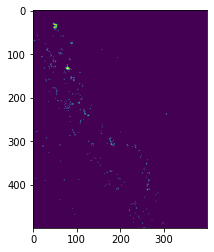

In [39]:
# Plot first year in time seroes
pyplot.imshow(mature_floodpln_euc[0])

In [41]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(mature_floodpln_euc_xarray["mature_floodpln_euc"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-Mature_floodplain_euc_{}.tif'.format(site_name.replace(" ","_"), year)))

In [42]:
for i, year in enumerate(classification_years):
    pixels_class = mature_floodpln_euc[i][mature_floodpln_euc[i] == 1].size
    area_class = pixels_class * (target_size["target_pixel_size_x"] * abs(target_size["target_pixel_size_y"]))
    print("{}: {} pixels, {} m2".format(year, pixels_class, area_class))

2005: 547 pixels, 547000000 m2
2010: 877 pixels, 877000000 m2
2015: 233 pixels, 233000000 m2
2017: 782 pixels, 782000000 m2


### State - Reference
#### Expression - Reduced tree canopy with wetland, grassland or chenopod understorey
<img src="Illustrations/Floodplain_eucalypt_woodlands_and_forests.jpg" style="width:300px;height:200px"/>
Dominated by Eucalyptus camaldulensis or E. largiflorens with a shrub layer of Exocarpus strictus and lignum species. the herbaceous layer typically includes Carex tereticaulis, Paspalidium jubiflorum, Centipeda cunninghamii, Alternanthera denticulata, Marsilea drummondii, Amphibromus sp. and Rytidosperma sp.


https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/floodplain-eucalypt-woodlands-and-forests/partial-tree-canopy/

|   |   |
|---|---|
| NTV|112|
| Water Persistence|0 weeks to <1 month (drought causing tree death)|
| Water seasonality|Spring snowmelt (late winter) to spring|
| No layers|3| 


   
|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Trees|na|10-50|> 3|Broadleaf|Evergreen|Clustered|Euc. camaldulensis or E. largiflorens|32-225|
|2|Shrubs|na|0-5|1-2|Aphyllous |Evergreen and drought deciduous (if lignum) |Clustered   |Exocarpus strictus, lignum ||
|3|Mixed Forbs and graminoids|includes both (uncommon)|10-50|<1.5|Broadleaf|Mixed annual/perennial|Continuous|Carex tereticaulis, Paspalidium jubiflorum, Centipeda cunninghamii, Alternanthera denticulata, Marsilea drummondii, Amphibromus sp., Rytidosperma sp.|| 

AVAILABLE DATA
level3, 
lifeform_veg_cat_l4a, 
canopyco_veg_cat_l4d, 
watersea_veg_cat_l4a, 
waterstt_wat_cat_l4a, 
waterper_wat_cat_l4d, 
inttidal_wat_cat_l4a, 
cci_biomass, 
woodyfractn, 
burnedareas, 
waterpersis, 
hgt25pccov, 
hgt50pccov, 
hgt75pccov, 
hgt95pccov, 
hgtpeakccov, 
fraccovlt5m, 
fraccov510m, 
fraccov1030m, 
fraccovgt30m, 
totalfraccov, 
npvpercov50,
pvpercov50,
woodyfracav

<img src="Illustrations/LUTLCCSCodes.jpg" style="width:320px;height:140px"/>
Woody Fraction (%): 0 to 0.1 (representing 0 to 100 %), Above ground biomass (Mg ha-1): 0 to 300 Mg ha-1,Frequency of burn (number): 0 to 35+, Time since last burn (years): 0 to 35 years

In [ ]:
partial_tree_canopy = numpy.where((classification_all["level3"].values == 112) &
                      (classification_all["cci_biomass"].values >= 32) & (classification_all["cci_biomass"].values <= 225) &
                      (classification_all["canopyco_veg_con"].values >= 10 ) & (classification_all["canopyco_veg_con"].values <= 50), 1, 0)

In [ ]:
 # Convert to xarray
partial_tree_canopy_xarray = xarray.Dataset(
    {"partial_tree_canopy" : (classification_all["level3"].dims, partial_tree_canopy)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(partial_tree_canopy[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(partial_tree_canopy_xarray["partial_tree_canopy"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-Partial_tree_canopy_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Reference
#### Expression - Dense seedling eucalypts
<img src="Illustrations/Floodplain_eucalypt_woodlands_and_forests.jpg" style="width:300px;height:200px"/>
Germination of floodplain eucalypt seed is promoted by episodic flooding, leading to dense stands or patches of seedling eucalypts. These may be associated with reduced density of overstorey trees if the mature trees were damaged by floods. Flooding may also promote a temporary shift towards more aquatic plant species in the understorey.

https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/floodplain-eucalypt-woodlands-and-forests/overview/


|   |   |
|---|---|
| NTV|112|
| Water Persistence|2 weeks to 6 months (4-6 months at wettest end) in most years|
| Water seasonality|Spring snowmelt (late winter) to spring|
| No layers|1| 
   
|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Graminoids, forbs, subshrubs|Free-floating forbs and Rooted forbs|0-40|0.03-1.5|Monocot and broadleaf|Annual and perennial|Clustered|Carex tereticaulis, Eleocharis acuta, Cycnogeton sp., Paspalidium jubiflorum, Centipeda cunninghamii, Poa labillardieri, Alternanthera denticulata, Marsilea drummondii, Amphibromus sp., Rytidosperma sp.|3.5-4|


In [ ]:
dense_seedling_euc = numpy.where((classification_all["level3"].values == 112) &
                     ((classification_all["cci_biomass"].values >= 3.5) & (classification_all["cci_biomass"].values <= 4)) &
                      (classification_all["canopyco_veg_con"].values >= 0 ) & (classification_all["canopyco_veg_con"].values <= 40), 1, 0)

In [ ]:
 # Convert to xarray
dense_seedling_euc_xarray = xarray.Dataset(
    {"dense_seedling_euc" : (classification_all["level3"].dims, dense_seedling_euc)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(dense_seedling_euc[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(dense_seedling_euc_xarray["dense_seedling_euc"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-dense_seedling_euc_{}.tif'.format(site_name.replace(" ","_"), year)))

### **State - Reference / Reduced tree canopy cover over invaded understorey / Invaded mature floodplain eucalypt forests and woodlands
#### Expression - Dense pole stage eucalypt stands
<img src="Illustrations/Floodplain_eucalypt_woodlands_and_forests.jpg" style="width:300px;height:200px"/>
Survival of seedlings after mass recruitment events depends on adequate follow-up rainfall, protection from herbivory and subsequent flooding. Low levels of competition from adult trees also promote survival – favouring survival in areas where trees were removed by flooding. These interacting drivers can result in a pattern of patchy stands of pole-stage eucalypts across a landscape. Where there is adequate post-flood moisture for survival, young eucalypts in dense regeneration stands are subject to density dependent thinning, likely expedited during dry periods and eventually resulting in the mature woodland structure.


https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/floodplain-eucalypt-woodlands-and-forests/dense-pole-stage-eucalypt-stands/


|   |   |
|---|---|
| NTV|112|
| Water Persistence|2 weeks to 6 months (4-6 months at wettest end) in most years |
| Water seasonality|Spring snowmelt (late winter) to spring|
| No layers|1-2| 


   
|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Woody|na|20-80|0.25-3|Broadleaf|Evergreen|Fragmented (striped or cellular)|Eucalyptus camaldulensis or E. largiflorens|66-103|
|2|Graminoids, forbs, subshrubs|Free-floating forbs and Rooted forbs|0-20|<1.5|Aphyllous |Evergreen and drought deciduous (if lignum) |Scattered (isolated)|Einadia sp.|| 

In [191]:
dense_pole_euc = numpy.where((classification_all["level3"].values == 112) &
                             (classification_all["tasscapwetn"] > -0.1) &
                             (classification_all["cci_biomass"].values <=103) &
                             (classification_all["canopyco_veg_con"].values >= 20 ) & (classification_all["canopyco_veg_con"].values <= 80), 1, 0)

In [192]:
# Convert to xarray
dense_pole_euc_xarray = xarray.Dataset(
    {"dense_pole_euc" : (classification_all["level3"].dims, dense_pole_euc)},
    coords=classification_all.coords)

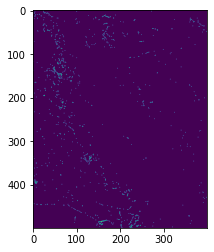

In [193]:
pyplot.imshow(dense_pole_euc[0])

In [190]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(dense_pole_euc_xarray["dense_pole_euc"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-dense_pole_euc_{}.tif'.format(site_name.replace(" ","_"), year)))

### **State - Reduced tree canopy over invaded understorey / Invaded mature floodplain eucalypt forests and woodlands / Halophytic state 
#### Expression - Reduced tree canopy over invaded understorey 
#<img src="Illustrations/Chenopods_shrublands2.jpg" style="width:300px;height:200px"/> #Update from Susanne

This expression is found in three modified states. The key differences from the reference state expression:Reduced tree canopy with wetland, grassland or chenopod understorey are (i) wet or dry understorey invaded by exotic plants (although still typically including hardy and colonising native plants species). Exacerbation of this ‘reduced tree canopy over invaded understorey’ expression is driven by selective logging, ringbarking and/or reduced water availability, with or without livestock grazing where 
    reduced flooding (both frequency and duration) occurs, an increased proportion of invaded dry (compared with invaded wet) understorey is expected (here ‘dry’ refers to plant species that do not tolerate regular flooding, relative to ‘wet’ plant species adapted to regular flooding). Invasion in wet understoreys may decline with greater frequency and duration of floods.

|   |   |
|---|---|
| NTV|112|
| Water Persistence|0 weeks to <1 month (drought causing tree death)|
| Water seasonality|spring snowmelt (late winter) to spring|
| No layers|3| 


   
|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|trees|na|10-50|>3m|Broadleaf|Evergreen|Clustered|Eucalyptus camaldulensis or E. largiflorens|32-225| 
|2|Shrubs|na|0-5|1-2|Broadleaf or Aphyllous |Evergreen and drought deciduous (if lignum) |Clustered to isolated|Blackberry, Exocarpus strictus, lignum||
|3|Graminoid and forbs (wet)/chenopods (dry)|Free-floating forbs and Rooted forbs (uncommon)|10-90|<1m|Broadleaf|Mixed (forbs and graminoids)|Continuous|Cirsium, conyza, annual grasses (eg Bromus spp, in drier areas)|| 


https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/floodplain-eucalypt-woodlands-and-forests/

In [194]:
redu_tree_cover = numpy.where((classification_all["level3"].values == 112) & 
                             (classification_all["tasscapwetn"] >= -0.1) &
                             (classification_all["wcf_mask"].values ==1) &
                             (classification_all["canopyco_veg_con"].values > 15 ) & (classification_all["canopyco_veg_con"].values <= 65) & 
                             ((classification_all["cci_biomass"].values > 20) & (classification_all["cci_biomass"].values <= 225)), 1, 0)

In [195]:
# Convert to xarray
redu_tree_cover_xarray = xarray.Dataset(
    {"redu_tree_cover" : (classification_all["level3"].dims, redu_tree_cover)},
    coords=classification_all.coords)

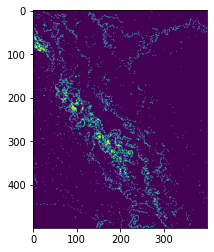

In [196]:
pyplot.imshow(redu_tree_cover[0])

In [197]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(redu_tree_cover_xarray["redu_tree_cover"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-Redu_tree_cover_{}.tif'.format(site_name.replace(" ","_"), year)))

In [166]:
for i, year in enumerate(classification_years):
    pixels_class = redu_tree_cover[i][redu_tree_cover[i] == 1].size
    area_class = pixels_class * (target_size["target_pixel_size_x"] * abs(target_size["target_pixel_size_y"]))
    print("{}: {} pixels, {} m2".format(year, pixels_class, area_class))

2005: 7643 pixels, 7643000000 m2
2010: 7269 pixels, 7269000000 m2
2015: 7644 pixels, 7644000000 m2
2017: 7460 pixels, 7460000000 m2


### **State - Invaded mature floodplain eucalypt forests and woodlands
#### Expression - Invaded mature floodplain eucalypt forests and woodlands 


This expression is found in the Invaded mature floodplain eucalypt forests and woodlands state only. The key differences from the reference state expression: Mature floodplain eucalypt forests and woodlands involves exotic plant invasion in the understorey, due to cumulative stressors including recreational use, nutrient input, livestock grazing, kangaroo overgrazing and water stress. If these cumulative stressors are removed, wet invaded understoreys may recover with flooding, and wet or dry invaded understoreys may recover through exclusion of exotic understorey species during dense pole-stage regeneration (this process is unproven but feasible). 

|   |   |
|---|---|
| NTV|112|
| Water Persistence|2 weeks to 6 months (4-6 months at wettest end) in at least 1 in 15-20 years (dry Black box) in most years for wettest red gum|
| Water seasonality|spring snowmelt (late winter) to spring|
| No layers|3| 


   
|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|trees|na|10-70|>3m|Broadleaf|Evergreen|Continuous|Eucalyptus camaldulensis or E. largiflorens|148-375| 
|2|Shrubs|na|0-5|1-2|Broadleaf or Aphyllous |Evergreen and drought deciduous (if lignum) |Clustered to isolated|Blackberry, Exocarpus strictus, lignum||
|3|Graminoid and forbs (wet)/chenopods (dry)|Free-floating forbs and Rooted forbs (uncommon)|10-90|0.01-0.7m|Broadleaf|Mixed (forbs and graminoids)|Continuous|ground cherry (Physalis), Bromus (dry), Fumaria spp, Gallium aparine|| 


https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/floodplain-eucalypt-woodlands-and-forests/

In [198]:
invade_mat = numpy.where((classification_all["level3"].values == 112) & 
                         (classification_all["tasscapwetn"] >= -0.1) &
                         (classification_all["wcf_mask"].values >= 0.2) &
                         (classification_all["canopyco_veg_con"].values >= 65) &
                        ((classification_all["cci_biomass"].values >=32) & (classification_all["cci_biomass"].values >=32)), 1, 0)

In [199]:
# Convert to xarray
invade_mat_xarray = xarray.Dataset(
    {"invade_mat" : (classification_all["level3"].dims, invade_mat)},
    coords=classification_all.coords)

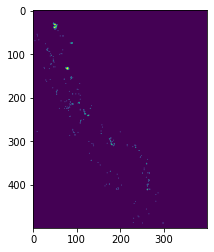

In [200]:
pyplot.imshow(invade_mat[0])

In [201]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(invade_mat_xarray["invade_mat"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-Invade_mat_{}.tif'.format(site_name.replace(" ","_"), year)))

In [72]:
for i, year in enumerate(classification_years):
    pixels_class = invade_mat[i][invade_mat[i] == 1].size
    area_class = pixels_class * (target_size["target_pixel_size_x"] * abs(target_size["target_pixel_size_y"]))
    print("{}: {} pixels, {} m2".format(year, pixels_class, area_class))

2005: 547 pixels, 547000000 m2
2010: 877 pixels, 877000000 m2
2015: 233 pixels, 233000000 m2
2017: 782 pixels, 782000000 m2


### **State - Reduced tree canopy over invaded understorey / Invaded mature floodplain eucalypt forests and woodlands / Halophytic state
#### Expression - Dense seedling eucalypts with invaded understorey


This expression is found in all three modified states of the Inland Floodplain eucalypt forests and woodlands. The key differences from the reference state expression involves exotic plant invasion, due to cumulative stressors including recreational use, nutrient input, livestock grazing, kangaroo overgrazing and water stress. If these cumulative stressors are removed, wet invaded understoreys may recover with flooding, and wet or dry invaded understoreys may recover through exclusion of exotic understorey species during dense pole-stage regeneration (this process is unproven but feasible). 

|   |   |
|---|---|
| NTV|112|
| Water Persistence|2 weeks to 6 months (4-6 months at wettest end)|
| Water seasonality|spring snowmelt (late winter) to spring|
| No layers|1| 


   
|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Herbaceous (graminoids, forbs, subshrubs)/chenopods (dry)|Free-floating forbs and Rooted forbs |0-40|0.03-1.5m|Broadleaf and Monocot|Mixed (forbs and graminoids)|Continuous to scattered|Carex tereticaulis, Eleocharis acuta, Cycnogeton sp., Paspalidium jubiflorum, Centipeda cunninghamii, Poa labillardieri, Alternanthera denticulata, Marsilea drummondii, Amphibromus sp., Rytidosperma sp.|3.5-4| 


https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/floodplain-eucalypt-woodlands-and-forests/


In [202]:
seedling_invaded = numpy.where((classification_all["level3"].values == 112) & 
                               (classification_all["tasscapwetn"] >= -0.1) &
                               (classification_all["wcf_mask"].values ==1) &
                               (classification_all["canopyco_veg_con"].values > 15 ) & (classification_all["canopyco_veg_con"].values <= 65) & 
                               (classification_all["cci_biomass"].values < 20), 1, 0)

In [203]:
# Convert to xarray
seedling_invaded_xarray = xarray.Dataset(
    {"seedling_invaded" : (classification_all["level3"].dims, seedling_invaded)},
    coords=classification_all.coords)

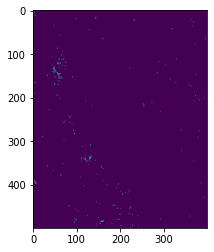

In [204]:
pyplot.imshow(seedling_invaded[0])

In [205]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(seedling_invaded_xarray["seedling_invaded"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-seedling_invaded_{}.tif'.format(site_name.replace(" ","_"), year)))

In [78]:
for i, year in enumerate(classification_years):
    pixels_class = seedling_invaded[i][seedling_invaded[i] == 1].size
    area_class = pixels_class * (target_size["target_pixel_size_x"] * abs(target_size["target_pixel_size_y"]))
    print("{}: {} pixels, {} m2".format(year, pixels_class, area_class))

2005: 25621 pixels, 25621000000 m2
2010: 15650 pixels, 15650000000 m2
2015: 14996 pixels, 14996000000 m2
2017: 21409 pixels, 21409000000 m2


### State - Halophytic state
#### Expression - Invaded halophytic shrubland


This expression is found only in the halophytic state. Initial salinisation in inland floodplain eucalypt forests and woodlands leads to the expression ‘reduced tree canopy with halophytic and invaded understorey’, stimulated by drivers such as irrigation causing rising saline water tables. Ongoing salinisation leads to eventual complete canopy tree loss, resulting in invaded halophytic shrubland (initially with dead trees persisting). It is uncertain whether lowering the water table (e.g. cessation of regular irrigation) and flushing (e.g. through heavy rains and occasional flooding) can result in recovery to non-saline, invaded wetland (e.g. ‘low condition wetland’ modified state), grassland or chenopod shrubland. If it occurs, it would be over long timeframes.  

|   |   |
|---|---|
| NTV|112|
| Water Persistence|no data|
| Water seasonality|no data|
| No layers|2| 


   
|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Shrubs|na|20-50|0.3-1.0m|Broadleaf|Evergreen|Continuous|salt tolerant succulents|no data| 
|2|Herbaceous (graminoids, forbs, subshrubs)|na|10-50|0-0.3m|Broadleaf|Evergreen|Continuous to scattered|Mesembryanthemum spp.|| 


https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/floodplain-eucalypt-woodlands-and-forests/

In [ ]:
halophytic_shrub = numpy.where((classification_all["level3"].values == 112) &
                      (classification_all["canopyco_veg_con"].values >= 20 ) & (classification_all["canopyco_veg_con"].values <= 50), 1, 0)

In [ ]:
# Convert to xarray
halophytic_shrub_xarray = xarray.Dataset(
    {"halophytic_shrub" : (classification_all["level3"].dims, halophytic_shrub)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(halophytic_shrub[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(halophytic_shrub_xarray["halophytic_shrub"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-halophytic_shrub_{}.tif'.format(site_name.replace(" ","_"), year)))

##### ANNA TO CHECK
#extent = halophytic_shrub_xarray.to_dataframe()
#extent2 = extent.sum(axis = 0, skipna = True)
#extent2

## AEM: Re-sprouter subtropical and temperate eucalypt woodlands

The archetype Re-sprouter temperate and subtropical eucalypt woodlands are dominated by an open woodland of re-sprouter eucalypts with a mixed-age distribution. Tree stand structures are thought to be typically mixed age through gap-phase recruitment. The understorey can be dominated by shrubs, or by C3 and C4 tussock grasses with diverse native forbs. The probability of shrub dominance in the understorey increases with decreasing ecosystem productivity, related to increasing aridity and/or decreasing soil fertility. Along this productivity gradient, low intensity fires can increase the relative prominence of the grass layer. C3 grasses are more common in southern parts of Australia, and C4 grasses are prominent in the north or with more frequent fire. In mesic areas of eastern Australia, most often west of the Great Divide and associated tablelands, Callitris can become prominent, leading to mixed eucalypt-Callitris woodlands . 

### **State - Reference
#### Expression - Grey box grassy woodlands

The ‘grey box grassy woodlands’ expression is characterised by an understorey of tussock grasses with diverse native forbs, scattered or patchy shrubs, and by a suite of re-sprouter eucalypts in the overstorey. At GKP typical genera in the understorey include Austrodanthonia, Themeda, Allocasuarina, Exocarpos and Dodonaea. Broadly, grassy woodlands predominate in mesic parts of the woodland zone, with the grassy understorey likely also promoted by low intensity fires (although Aboriginal burning regimes are not well documented for this expression). Evidence of fire in grey box grassy woodland landscapes at GKP is minimal. It is unclear whether observed scar trees indicate more frequent fires in the past and lower tree density than compared to the present. Fire may have occurred in this expression, but current observed fuel loads are quite low, indicating this is unlikely. This expression does not tolerate regular inundation.

https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/re-sprouter-temperate-and-subtropical-eucalypt-woodlands/grey-box-regular-inundated/

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na
| No layers|3| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Woody|na|10-20|25-30m|Broadleaf|Evergreen|Scattered|Eucalyptus microcarpa|no data|
|2|Woody and herbaceous|na|10|2m|Broadleaf|Evergreen|Scattered|Allocasuarina, Senna, Dodonaea, Exocarpos aphyllus||
|3|Herbaceous|na|80|0.05-0.25m|Monocot and broadleaf|Evergreen|Continuous|Themeda sp.||


In [206]:
grey_box_grassy = numpy.where((classification_all["level3"].values == 112) &
                             (classification_all["tasscapwetn"] < -0.1) &
                             (classification_all["wcf_mask"].values ==1) &
                             (classification_all["canopyco_veg_con"].values > 15 ) & (classification_all["canopyco_veg_con"].values <= 65) & 
                             ((classification_all["cci_biomass"].values >=20) & (classification_all["cci_biomass"].values < 150)), 1, 0)

In [207]:
# Convert to xarray
grey_box_grassy_xarray = xarray.Dataset(
    {"grey_box_grassy" : (classification_all["level3"].dims, grey_box_grassy)},
    coords=classification_all.coords)

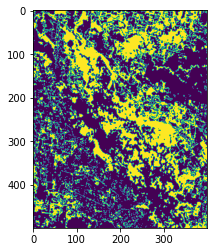

In [208]:
pyplot.imshow(grey_box_grassy[0])

In [209]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(grey_box_grassy_xarray["grey_box_grassy"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-grey_box_grassy_{}.tif'.format(site_name.replace(" ","_"), year)))

In [105]:
for i, year in enumerate(classification_years):
    pixels_class = grey_box_grassy[i][grey_box_grassy[i] == 1].size
    area_class = pixels_class * (target_size["target_pixel_size_x"] * abs(target_size["target_pixel_size_y"]))
    print("{}: {} pixels, {} m2".format(year, pixels_class, area_class))

2005: 76600 pixels, 76600000000 m2
2010: 60378 pixels, 60378000000 m2
2015: 63847 pixels, 63847000000 m2
2017: 66227 pixels, 66227000000 m2


## **State - Reference
#### Expression - Grey box shrub-grass woodlands
<img src="Illustrations/Chenopods_shrublands2.jpg" style="width:300px;height:200px"/>

This ecosystem expression occurs in more arid or less productive environments than the ‘grey box grassy woodlands’ expression. It has a more consistently developed shrub layer above the grassy understorey. Episodic fire after good rains promotes grass growth, preventing the shrub layer from becoming more continuous. At GKP there is scant evidence of historical fire regimes; however, the ‘grey box shrub-grass woodlands’ expression can have higher fuel loads and if fires occurred they may have been hotter, and large trees might have been killed. This expression is maintained by infrequent and short duration inundation events (e.g. one in every 30 years). Common species in the understorey include Myoporum montanum, Exocarpos aphyllus, Acacia oswaldii, A. acinacea, Austrodanthonia sp. and native forbs.  

https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/re-sprouter-temperate-and-subtropical-eucalypt-woodlands/grey-box-irregular-inundated/

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na
| No layers|3| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Woody|na|30|25-30m|Broadleaf|Evergreen|Scattered|Eucalyptus microcarpa|no data|
|2|Woody|na|10|2m|Broadleaf|Evergreen|Scattered|Myoporum montanum, Exocarpos aphyllus, Acacia oswaldii, Acacia acinacea||
|3|Herbaceous|na|60|0.05-0.25m|Monocot and broadleaf|Evergreen|Continuous but fragmented|Austrodanthonia sp.||

In [210]:
grey_box_shrub_grass = numpy.where((classification_all["level3"].values == 112) & 
                                   (classification_all["tasscapwetn"] < -0.1) &
                                   (classification_all["wcf_mask"].values ==1) &
                                   (classification_all["canopyco_veg_con"].values > 15 ) & (classification_all["canopyco_veg_con"].values <= 65) & 
                                  ((classification_all["cci_biomass"].values >=20) & (classification_all["cci_biomass"].values < 150)), 1, 0)

In [211]:
# Convert to xarray
grey_box_shrub_grass_xarray = xarray.Dataset(
    {"grey_box_shrub_grass" : (classification_all["level3"].dims, grey_box_shrub_grass)},
    coords=classification_all.coords)

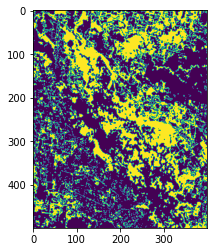

In [212]:
pyplot.imshow(grey_box_shrub_grass[0])

In [225]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(grey_box_shrub_grass_xarray["grey_box_shrub_grass"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-grey_box_shrub_grass_{}.tif'.format(site_name.replace(" ","_"), year)))

OSError: File exists

In [214]:
for i, year in enumerate(classification_years):
    pixels_class = grey_box_shrub_grass[i][grey_box_shrub_grass[i] == 1].size
    area_class = pixels_class * (target_size["target_pixel_size_x"] * abs(target_size["target_pixel_size_y"]))
    print("{}: {} pixels, {} m2".format(year, pixels_class, area_class))

2005: 74670 pixels, 74670000000 m2
2010: 58516 pixels, 58516000000 m2
2015: 61933 pixels, 61933000000 m2
2017: 64386 pixels, 64386000000 m2


## State - Grey box woodlands with exotic understorey
#### Expression - Grey box grassy woodland with exotic understorey
<img src="Illustrations/Chenopods_shrublands2.jpg" style="width:300px;height:200px"/>

The Grey box woodlands with exotic understory state is predominantly evident in the ‘grey box grassy woodlands with exotic understorey’ expression, where soil disturbance from grazing and recreation has led to the invasion of the understorey by exotic species that do not tolerate frequent inundation. The canopy species (predominantly E. microcarpa) are denser and of a uniform age structure in both expressions of the modified state relative to the reference state. It is unclear what the drivers are of the modified stand structure, although extensive grazing limits further recruitment of overstorey species. Understorey composition in this expression includes exotic understorey species such as Marrubium vulgare, Echium plantagineum, Asparagus asparagoides, Opuntia spp., Heliotropium europaeum, Lolium sp., Hypericum perforatum, Physalis hederifolia, Hordeum leporinum and Genista monspessulana. Fire is no longer present in these woodlands and the understorey tends to be drier and more open than in the reference state. 

https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/re-sprouter-temperate-and-subtropical-eucalypt-woodlands/shrub-grass-woodland/

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na
| No layers|3| 
 
 
|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Woody|na|10-20|25-30m|Broadleaf|Evergreen|Scattered|Eucalyptus microcarpa|99|
|2|Woody and herbaceous|na|1-5|1|Broadleaf|Evergreen|Scattered (clustered)|Opuntia spp., Genista monspessulana||
|3|Herbaceous|na|30-50|0.05-0.15|Monocot and broadleaf|Evergreen|Continous with gaps|Marrubium vulgare, Echium plantagineum, Asparagus asparagoides, Heliotropium europaeum||

In [215]:
grey_box_grassy_exotic = numpy.where((classification_all["level3"].values == 112) & 
                                     (classification_all["tasscapwetn"] < -0.1) &
                                     (classification_all["wcf_mask"].values ==1) &
                                     (classification_all["canopyco_veg_con"].values > 15 ) & (classification_all["canopyco_veg_con"].values <= 65) & 
                                    ((classification_all["cci_biomass"].values >=20) & (classification_all["cci_biomass"].values < 150)), 1, 0)

In [216]:
 # Convert to xarray
grey_box_grassy_exotic_xarray = xarray.Dataset(
    {"grey_box_grassy_exotic" : (classification_all["level3"].dims, grey_box_grassy_exotic)},
    coords=classification_all.coords)

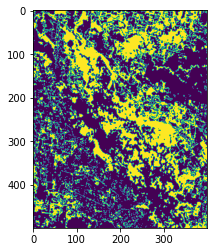

In [217]:
pyplot.imshow(grey_box_grassy_exotic[0])

In [218]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(grey_box_grassy_exotic_xarray["grey_box_grassy_exotic"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-grey_box_grassy_exotic_{}.tif'.format(site_name.replace(" ","_"), year)))

In [180]:
for i, year in enumerate(classification_years):
    pixels_class = grey_box_grassy_exotic[i][grey_box_grassy_exotic[i] == 1].size
    area_class = pixels_class * (target_size["target_pixel_size_x"] * abs(target_size["target_pixel_size_y"]))
    print("{}: {} pixels, {} m2".format(year, pixels_class, area_class))

2005: 74670 pixels, 74670000000 m2
2010: 58516 pixels, 58516000000 m2
2015: 61933 pixels, 61933000000 m2
2017: 64386 pixels, 64386000000 m2


## State - Grey box woodlands with exotic understorey
#### Expression - Grey box shrub-grass woodlands with denuded understorey
<img src="Illustrations/Chenopods_shrublands2.jpg" style="width:300px;height:200px"/>

In the ‘grey box shrub-grass woodland with denuded understorey’ expression, inundation frequency is of a longer duration than the reference (from weeks to several (2 to 3) months), which may result in the presence of flood-tolerant flora such as sedges and rushes, including exotic species such as Phyla canescens. This expression may have extensive areas with no understorey species (leaf litter and coarse woody debris dominate the understorey below dense canopy cover).  

https://australia.livingearth.online/themes/australian-ecosystems/eucalypt-woodlands/re-sprouter-temperate-and-subtropical-eucalypt-woodlands/shrub-grass-woodland/

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na
| No layers|1| 
 
 
|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Woody|na|30|25-30m|Broadleaf|Evergreen|Continuous|Eucalyptus microcarpa|99|

In [219]:
grey_box_shrubby_denuded = numpy.where((classification_all["level3"].values == 112) & 
                                       (classification_all["tasscapwetn"] < -0.1) &
                                       (classification_all["wcf_mask"].values ==1) &
                                       (classification_all["canopyco_veg_con"].values > 1 ) & (classification_all["canopyco_veg_con"].values <= 10) & 
                                       (classification_all["cci_biomass"].values < 99), 1, 0)

In [220]:
 # Convert to xarray
grey_box_shrubby_denuded_xarray = xarray.Dataset(
    {"grey_box_shrubby_denuded" : (classification_all["level3"].dims, grey_box_shrubby_denuded)},
    coords=classification_all.coords)

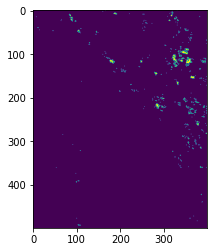

In [221]:
pyplot.imshow(grey_box_shrubby_denuded[0])

In [222]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(grey_box_shrubby_denuded_xarray["grey_box_shrubby_denuded"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-grey_box_shrubby_denuded_{}.tif'.format(site_name.replace(" ","_"), year)))

In [223]:
for i, year in enumerate(classification_years):
    pixels_class = grey_box_shrubby_denuded[i][grey_box_shrubby_denuded[i] == 1].size
    area_class = pixels_class * (target_size["target_pixel_size_x"] * abs(target_size["target_pixel_size_y"]))
    print("{}: {} pixels, {} m2".format(year, pixels_class, area_class))

2005: 1490 pixels, 1490000000 m2
2010: 32 pixels, 32000000 m2
2015: 9703 pixels, 9703000000 m2
2017: 2636 pixels, 2636000000 m2


## AEM: Callitris Woodlands

The Callitris archetype model reflects two different dynamics for Callitris woodlands. The first dynamic relates to ecosystems dominated by Callitris in areas protected from repeated and severe disturbance. Here, Callitris woodlands may undergo both gap phase and stand recruitment dynamics in response to mild to moderate disturbances. These dynamics are based on our understanding of other obligate seeding species (Gosper et al., 2018) as there is limited knowledge about the validity of these dynamics. Differences in serotiny (ie. degree to which seeds retained in canes until fire causes release) among Callitris species may lead to differences in response to extensive fires. Callitris glaucophylla is purportedly non-serotinous and its seeds are poorly dispersed (Prior & Bowman 2020), hence recruitment may only be stimulated by fire or other disturbance when these are patchy or small enough in area to enable recruitment from nearby mature plants. 

A second dynamic is represented when Callitris species occur in a matrix of different woodland types; the dynamics of these systems are included in the relevant woodland archetype model (e.g. eucalypt woods, mallee woodlands). A second knowledge gap is whether it is possible to shift between these two dynamics (dominant Callitris stands versus woodlands with co-dominant Callitris species) under endogenous disturbance regimes.  

https://australia.livingearth.online/themes/australian-ecosystems/callitris-forests-and-woodlands/


### State - Reference
#### Expression - Sandhill pine woodlands

At GKP, Callitris glaucophylla – dominated woodlands (termed sandhill pine woodlands) occurred on small sand rises across the floodplain. Currently, these woodlands are highly transformed and no longer resemble the reference state. It is likely the occurrence of these woodlands is edaphically driven but it may also be due to protection from fire afforded by their presence within a regularly inundated floodplain. There is no evidence of a fire dynamic between sandhill pine woodlands and the surrounding floodplain wetlands, floodplain eucalypt forests and woodlands, and grey box grassy woodlands; therefore, the reference model for Callitris woodlands (sandhill pine woodlands) retains only the central expressions that represent stand recruitment and gap phase dynamics in woodlands dominated by Callitris. 

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na
| No layers|3| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Woody|na|15-20|20-25m|Needleleaved|Evergreen|Scattered|Callitris glaucophylla, Callitris gracilis|no data|
|2|Woody|na|2-3|5|Broadleaf|Evergreen|Fragmented|Acacia oswaldii, Santalum acuminatum, Senna sp., Pittosporum angustifolium, Dodonaea viscosa, Calytrix tetragona, Santalum lanceolatum||
|3|Herbaceous|na|70|0.02m|Monocot|Evergreen|Continous with gaps|Panicum effusum, Austrostipa nodosa, A. platychaeta, Thysanotus baueri, Pterostylis sp.||

In [ ]:
sandhill_pines = numpy.where((classification_all["level3"].values == 112) &
                      (classification_all["canopyco_veg_con"].values >=15 ) & (classification_all["canopyco_veg_con"].values <= 20), 1, 0)

In [ ]:
 # Convert to xarray
sandhill_pines_xarray = xarray.Dataset(
    {"sandhill_pines" : (classification_all["level3"].dims, sandhill_pines)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(sandhill_pines[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(sandhill_pines_xarray["sandhill_pines"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-sandhill_pines_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Low rise sandhill pine woodlands
#### Expression - Senescent Allocasuarina over invaded understorey

The low rise sandhill pine woodlands occurs only in Gunbower Forest and are more intact (in terms of plant species composition) than the high rise sandhill pine woodlands. However, the dominant Callitris species (C. glaucophylla) has been lost from both states. Both modified states have been impacted due to grazing by introduced herbivores (deer, rabbits); grazing by abundant native grazers, such as kangaroos; and exotic plant invasion. Several grazing enclosures at GKP have been built to study the recovery of these woodlands when grazing is removed. Logging may also have occurred in these woodlands in the past.  

The low rise sandhill pine woodlands have a lower elevation above the floodplain and are smaller in area (approximately 5–10 ha) compared to the high rise sandhill pine woodlands (approximately 15–30 ha). The low rise sandhill pine woodlands also have higher clay contents, relative to the high rise woodlands, where soils are almost pure sand. Despite the loss of the dominant Callitris species, the low rise sandhill pine woodlands maintain a relatively intact vegetation structure with three layers: canopy, the understorey and ground layer. Canopy species may include senescent Allocasuarina leuhmannii and the understorey and ground layer are often dominated by exotic species such as Opuntia spp. and Asparagus asparagoides. Again, due to a lack of knowledge on ecosystem expressions under gap phase and stand replacement dynamics, a single expression has been described, representing mature woodlands for both the low rise sandhill pine woodlands (‘senescent Allocasuarina over invaded understorey’ expression). 

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na
| No layers|3| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Woody|na|10-70|10-15m|Needleleaved|Evergreen|Scattered|Allocasuarina leuhmannii|no data|
|2|Woody|na|1-4|2m|Broadleaf|Evergreen|Fragmented|Opuntia spp.||
|3|Herbaceous|na|10-70|0.05m|Monocot|Evergreen|Scattered (clustered)|Asparagus asparagoides||

In [ ]:
senes_allocasuarina = numpy.where((classification_all["level3"].values == 112) &
                      (classification_all["canopyco_veg_con"].values >=10 ) & (classification_all["canopyco_veg_con"].values <= 70), 1, 0)

In [ ]:
 # Convert to xarray
senes_allocasuarina_xarray = xarray.Dataset(
    {"senes_allocasuarina" : (classification_all["level3"].dims, senes_allocasuarina)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(senes_allocasuarina[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(senes_allocasuarina_xarray["senes_allocasuarina"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-senes_allocasuarina_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - High rise sandhill pine woodlands
#### Expression - Denuded canopy and no understorey strata

The high rise sandhill pine woodlands are dominated by exotic species and native canopy and mid-storey species are almost absent (occasionally Pittosporum angustifolium and Eucalyptus mellidora occur on the perimeter of the sandhill rises). This has likely resulted from erosion due to motorbikes and four-wheel drive recreational use; logging; and weed invasion associated with grazing by deer, rabbits and past cattle grazing. The high rise woodlands are particularly dominant in Koondrook-Perricoota Forest. Exotic understorey plant species include Marrubium vulgare, Echium plantagineum, Heliotropium europaeum, Asparagus asparagoides and Opuntia spp.

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na
| No layers|1| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Woody|na|1-4|25m|Broadleaf|Evergreen|Scattered|Marrubium vulgare, Echium plantagineum, Heliotropium europaeum, Asparagus asparagoides, Opuntia spp.|no data|

In [ ]:
denuded_sandhill = numpy.where((classification_all["level3"].values == 112) &
                      (classification_all["canopyco_veg_con"].values >=1 ) & (classification_all["canopyco_veg_con"].values <= 4), 1, 0)

In [ ]:
 # Convert to xarray
denuded_sandhill_xarray = xarray.Dataset(
    {"denuded_sandhill" : (classification_all["level3"].dims, denuded_sandhill)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(denuded_sandhill[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(denuded_sandhill_xarray["denuded_sandhill"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-denuded_sandhill_{}.tif'.format(site_name.replace(" ","_"), year)))

## AEM: Wetlands
https://australia.livingearth.online/themes/australian-ecosystems/wetlands/

Wetlands are very large and heterogeneous, encompassing different environments, with widely different dynamic drivers. Therefore, the archetype model represents the simplest set of possible dynamics, with transitions identified between open water bodies with submerged/fringing wetland vegetation; ephemeral water bodies and associated species adapted to fluctuating hydrological conditions; and the ultimate conversion to terrestrial vegetation in the absence of the water source. 

In the context of GKP, the simple archetype model template for wetlands has been modified to include six wetland expressions (these include three broad expressions: permanent, semi-permanent and temporary, which each have a predominantly wet and dry expression) (Figure 19). These broad expressions differ in terms of the frequency, duration, extent, timing and depth of inundation. These flood regimes vary spatially due to changes in the topography of the floodplain, including height and proximity to floodwaters. In addition, temporal changes to floodplain geomorphology over long timeframes through channel blockages, avulsions, anabranching and channel switching can alter water flow pathways and drive a shift between the different wetland expressions or to permanent aquatic systems, such as lowland streams. Geomorphological changes often result from long-term changes in rainfall patterns and combine with local sediment characteristics to determine the manifestation of different wetland expressions over time. Indigenous water management, such as via excavation of wetlands to increase flood duration (Pardoes and Hutton, 2017), can also drive shifts between expressions in the reference state. The different inundation regimes characterised in the model lead to different compositions and abundance of aquatic plants and faunal species in the wet and dry expressions. In particular, re-wetting of built-up litter (leaf, grass, woody debris) carbon during dry expressions can cause blackwater events resulting in an important flush of carbon into the water column in wet expressions.  

### State - Reference
#### Expression - Permanent wet

This expression experiences frequent and long duration flooding with almost permanent open water occurring in most years. As a result, mudflat flora present in the dry expression rarely include perennial species. Drying down generally occurs in GKP over summer and autumn, whereas wetting up occurs in spring. With a sufficient reduction in flood frequency and duration, woody species can colonise the wetland leading to a shift to inland floodplain eucalypt forests and woodlands via the thicket expression. This is most likely to occur at the edges of permanent wetlands, and it is likely that a smaller area of open water would remain. For the permanent wetlands that generally occur on the inner floodplain at GKP, common woody species are Eucalyptus camadulensis and aquatic understorey plants are typically observed in the understorey as waters recede. These species may be replaced by annuals/coloniser species and litter in the dry thicket expression.  

|   |   |
|---|---|
| NAV|124|
| Water Persistence|>9 months|
| Water Seasonality|semi-permanent|
| No layers|2| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Rooted forbs|Evergreen|>2m|Flows and stands as it contracts|Almost no sediment|5-7|no data|
|2|Floating herbs|Evergreen|||||||

In [ ]:
classification_all

In [ ]:
#FIXME: Modified for Australia specific LCCS classification - Check that the values are still as intended
permanent_wet = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["waterper_wat_cat_l4d"].values ==12) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1), 1, 0)

In [ ]:
 # Convert to xarray
permanent_wet_xarray = xarray.Dataset(
    {"permanent_wet" : (classification_all["level3"].dims, permanent_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(permanent_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(permanent_wet_xarray["permanent_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-permanent_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Reference
#### Expression - Semi-permanent wet

This expression has moderately frequent flooding of variable duration and is the most common wetland expression at GKP (on average 1–2 m water depth in the wet expression with duration of inundation between 4–18 months). These expressions have the highest density of vegetation and possibly the best developed mudflat flora, in terms of composition (including perennial mudflat and other amphibious species). Like the permanent wetlands, the semi-permanent wetlands may shift to a thicket expression dominated by E. camadulensis under reduced flood frequency and duration, where all areas of open water may shift to the thicket.    

|   |   |
|---|---|
| NAV|124|
| Water Persistence|>9 months|
| Water Seasonality|semi-permanent|
| No layers|2| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Rooted forbs|Evergreen|>2m|Flows and stands as it contracts|Almost no sediment|5-7|no data|
|2|Floating herbs|Evergreen|||||||

In [ ]:
#FIXME: Modified for Australia specific LCCS classification - Check that the values are still as intended
semi_permanent_wet = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["waterper_wat_cat_l4d"].values ==12) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1), 1, 0)

In [ ]:
 # Convert to xarray
semi_permanent_wet_xarray = xarray.Dataset(
    {"semi_permanent_wet" : (classification_all["level3"].dims, semi_permanent_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(semi_permanent_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(semi_permanent_wet_xarray["semi_permanent_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-semi_permanent_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Reference
#### Expression - Temporary wet

For temporary wetlands, the dry expression dominates and flooding depths are often shallow and of short duration. These wetlands are more common in the outer floodplain and less well connected to other wetlands on the floodplain (through ephemeral flood runners and anabranches). Shifts to the thicket expression may include woody species such as E. largiflorens and E. microcarpa, as well as E. camadulensis.     

|   |   |
|---|---|
| NAV|124|
| Water Persistence|1-3 months|
| Water Seasonality|temporary (weeks to months every five -nine years)|
| No layers|2| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Graminoids|Evergreen|<2m|Flows and stands as it contracts|Almost no sediment|5-7|no data|
|2|Floating herbs|Evergreen|||||||

In [ ]:
# FIXME: Richard - is it intential to use the level3 from 2017? Previously you've been using 2005.
temporary_wet = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["waterper_wat_cat_l4d"].values ==16) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==2), 1, 0)

In [ ]:
 # Convert to xarray
temporary_wet_xarray = xarray.Dataset(
    {"temporary_wet" : (classification_all["level3"].dims, temporary_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(temporary_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(temporary_wet_xarray["temporary_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-temporary_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Reference
#### Expression - Permanent dry

This expression experiences frequent and long duration flooding with almost permanent open water occurring in most years. As a result, mudflat flora present in the dry expression rarely include perennial species. Drying down generally occurs in GKP over summer and autumn, whereas wetting up occurs in spring. With a sufficient reduction in flood frequency and duration, woody species can colonise the wetland leading to a shift to inland floodplain eucalypt forests and woodlands via the thicket expression. This is most likely to occur at the edges of permanent wetlands, and it is likely that a smaller area of open water would remain. For the permanent wetlands that generally occur on the inner floodplain at GKP, common woody species are Eucalyptus camadulensis and aquatic understorey plants are typically observed in the understorey as waters recede. These species may be replaced by annuals/coloniser species and litter in the dry thicket expression.    

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water Seasonality|na|
| No layers|1| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Herbaceous|na|xxxxx|0.05-0.25m|Monocot and Broadleaf|Evergreen|Continous|XXXXXXX|no data|


In [ ]:
permanent_dry = numpy.where((classification_all["level3"].values == 112) &
                              (classification_all["canopyco_veg_con"].values >=79 ) & (classification_all["canopyco_veg_con"].values <= 81), 1, 0)

In [ ]:
 # Convert to xarray
permanent_dry_xarray = xarray.Dataset(
    {"permanent_dry" : (classification_all["level3"].dims, permanent_dry)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(permanent_dry[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(permanent_dry_xarray["permanent_dry"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-permanent_dry_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Reference
#### Expression - Semi-permanent dry

This expression has moderately frequent flooding of variable duration and is the most common wetland expression at GKP (on average 1–2 m water depth in the wet expression with duration of inundation between 4–18 months). These expressions have the highest density of vegetation and possibly the best developed mudflat flora, in terms of composition (including perennial mudflat and other amphibious species). Like the permanent wetlands, the semi-permanent wetlands may shift to a thicket expression dominated by E. camadulensis under reduced flood frequency and duration, where all areas of open water may shift to the thicket.     

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water Seasonality|na|
| No layers|1| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Herbaceous|na|xxxxx|0.05-0.25m|Monocot and Broadleaf|Evergreen|Continous|XXXXXXX|no data|

In [ ]:
semi_permanent_dry = numpy.where((classification_all["level3"].values == 112) &
                              (classification_all["canopyco_veg_con"].values >=79 ) & (classification_all["canopyco_veg_con"].values <= 81), 1, 0)

In [ ]:
 # Convert to xarray
semi_permanent_dry_xarray = xarray.Dataset(
    {"semi_permanent_dry" : (classification_all["level3"].dims, semi_permanent_dry)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(semi_permanent_dry[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(semi_permanent_dry_xarray["semi_permanent_dry"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-semi_permanent_dry_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Reference
#### Expression - Temporary dry

For temporary wetlands, the dry expression (see Figure 20) dominates and flooding depths are often shallow and of short duration. These wetlands are more common in the outer floodplain and less well connected to other wetlands on the floodplain (through ephemeral flood runners and anabranches). Shifts to the thicket expression may include woody species such as E. largiflorens and E. microcarpa, as well as E. camadulensis. The dry expression is usually dominated by a dense, less flood-tolerant graminoid component.     

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water Seasonality|na|
| No layers|1| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Herbaceous|na|xxxxx|0.05-0.25m|Monocot and Broadleaf|Evergreen|Continous|XXXXXXX|no data|


In [ ]:
temporary_dry = numpy.where((classification_all["level3"].values == 112) &
                              (classification_all["canopyco_veg_con"].values >=79 ) & (classification_all["canopyco_veg_con"].values <= 81), 1, 0)

In [ ]:
 # Convert to xarray
temporary_dry_xarray = xarray.Dataset(
    {"temporary_dry" : (classification_all["level3"].dims, temporary_dry)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(temporary_dry[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(temporary_dry_xarray["temporary_dry"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-temporary_dry_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - High condition wetlands
#### Expression - High condition permanent wet

This state is similar to the reference state and has low numbers of invasive fish species, such as carp and Gambusia, and may support a high diversity of native small-bodied fish. Many of the high condition wetlands at GKP display evidence of extended occupation and use by Aboriginal people (for 3000–4000 years). This state may have low or high cover of vegetation under wet expressions and, when deeply inundated, this state may have low plant diversity. Wet expressions generally have low levels of turbidity. Few exotic plants species are present in these wetlands and they may have a high cover and richness of terrestrial plant species when shallow or dry (mudflat). Grazing by native and introduced herbivores may reduce the cover and species richness of plants in the dry expression (e.g. through preferential grass removal) – this is the case for all states. Some encroachment of E. camadulensis may be observed on the margins of these wetlands.    

|   |   |
|---|---|
| NAV|124|
| Water Persistence|>9 months|
| Water Seasonality|semi-permanent|
| No layers|2| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Rooted forbs|Evergreen|>2m|Flows and stands as it contracts|Low turbidity|no data|no data|
|2|Floating herbs|Evergreen|||||||

In [ ]:
high_condition_permanent_wet = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["waterper_wat_cat_l4d"].values ==12) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1), 1, 0)

In [ ]:
 # Convert to xarray
high_condition_permanent_wet_xarray = xarray.Dataset(
    {"high_condition_permanent_wet" : (classification_all["level3"].dims, high_condition_permanent_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(high_condition_permanent_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(high_condition_permanent_wet_xarray["high_condition_permanent_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-high_condition_permanent_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - High condition wetland
#### Expression - High condition semi-permanent wet

This state is similar to the reference state and has low numbers of invasive fish species, such as carp and Gambusia, and may support a high diversity of native small-bodied fish. Many of the high condition wetlands at GKP display evidence of extended occupation and use by Aboriginal people (for 3000–4000 years). This state may have low or high cover of vegetation under wet expressions and, when deeply inundated, this state may have low plant diversity. Wet expressions generally have low levels of turbidity. Few exotic plants species are present in these wetlands and they may have a high cover and richness of terrestrial plant species when shallow or dry (mudflat). Grazing by native and introduced herbivores may reduce the cover and species richness of plants in the dry expression (e.g. through preferential grass removal) – this is the case for all states. Some encroachment of E. camadulensis may be observed on the margins of these wetlands.    

|   |   |
|---|---|
| NAV|124|
| Water Persistence|>9 months|
| Water Seasonality|semi-permanent|
| No layers|2| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Rooted forbs|Evergreen|>2m|Flows and stands as it contracts|low turbidity|no data|no data|
|2|Floating herbs|Evergreen|||||||

In [ ]:
high_condition_semi_permanent_wet = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["waterper_wat_cat_l4d"].values ==12) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1), 1, 0)

In [ ]:
 # Convert to xarray
high_condition_semi_permanent_wet_xarray = xarray.Dataset(
    {"high_condition_semi_permanent_wet" : (classification_all["level3"].dims, high_condition_semi_permanent_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(high_condition_semi_permanent_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(high_condition_semi_permanent_wet_xarray["high_condition_semi_permanent_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-high_condition_semi_permanent_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - High condition wetland
#### Expression - High condition temporary wet

This state is similar to the reference state and has low numbers of invasive fish species, such as carp and Gambusia, and may support a high diversity of native small-bodied fish. Many of the high condition wetlands at GKP display evidence of extended occupation and use by Aboriginal people (for 3000–4000 years). This state may have low or high cover of vegetation under wet expressions and, when deeply inundated, this state may have low plant diversity. Wet expressions generally have low levels of turbidity. Few exotic plants species are present in these wetlands and they may have a high cover and richness of terrestrial plant species when shallow or dry (mudflat). Grazing by native and introduced herbivores may reduce the cover and species richness of plants in the dry expression (e.g. through preferential grass removal) – this is the case for all states. Some encroachment of E. camadulensis may be observed on the margins of these wetlands.     

|   |   |
|---|---|
| NAV|124|
| Water Persistence|1-3 months|
| Water Seasonality|temporary (weeks to months every five -nine years)|
| No layers|2| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Graminoids|Evergreen|<2m|Flows and stands as it contracts|low turbidity|no data|no data|
|2|Floating herbs|Evergreen|||||||

In [ ]:
high_condition_temporary_wet = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["waterper_wat_cat_l4d"].values ==16) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==2), 1, 0)

In [ ]:
 # Convert to xarray
high_condition_temporary_wet_xarray = xarray.Dataset(
    {"high_condition_temporary_wet" : (classification_all["level3"].dims, high_condition_temporary_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(high_condition_temporary_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(high_condition_temporary_wet_xarray["high_condition_temporary_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-high_condition_temporary_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - High condition wetland
#### Expression - High condition mudflat

This state is similar to the reference state and has low numbers of invasive fish species, such as carp and Gambusia, and may support a high diversity of native small-bodied fish. Many of the high condition wetlands at GKP display evidence of extended occupation and use by Aboriginal people (for 3000–4000 years). This state may have low or high cover of vegetation under wet expressions and, when deeply inundated, this state may have low plant diversity. Wet expressions generally have low levels of turbidity. Few exotic plants species are present in these wetlands and they may have a high cover and richness of terrestrial plant species when shallow or dry (mudflat). Grazing by native and introduced herbivores may reduce the cover and species richness of plants in the dry expression (e.g. through preferential grass removal) – this is the case for all states. Some encroachment of E. camadulensis may be observed on the margins of these wetlands.     

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na|
| No layers|1| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Herbaceous|na|xxxxx|0.05-0.25m|Monocot and Broadleaf|Evergreen|Continous|XXXXXXX|no data|


In [ ]:
high_condition_mudflat = numpy.where((classification_all["level3"].values == 112) &
                      (classification_all["canopyco_veg_con"].values >=79 ) & (classification_all["canopyco_veg_con"].values <= 81), 1, 0)

In [ ]:
 # Convert to xarray
high_condition_mudflat_xarray = xarray.Dataset(
    {"high_condition_mudflat" : (classification_all["level3"].dims, high_condition_mudflat)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(high_condition_mudflat[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(high_condition_mudflat_xarray["high_condition_mudflat"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-high_condition_mudflat_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Moderate condition wetlands
#### Expression - Moderate condition permanent wet

This state has a moderate species richness and cover of macrophytes and perennial species in the dry expressions if slower dry down occurs in spring. If water recession occurs in summer, water temperature and turbidity increase (this may be due to carp activity), leading to loss of macrophyte species. These conditions may also promote algae growth leading to low light penetration and low biological activity in the water column. Rates of inundation are likely to be lower than high condition states and encroachment by E. camadulensis may be more extensive in water depths of 2 m or lower. High waterbird diversity and the presence of colonial breeding can be observed in this state, and numbers of invasive carp may be kept low when bird numbers are high. This state may have high or low cover of vegetation in the wet expressions. The main differences between this state and the high condition state are the lower species richness and cover of plant species, either in the wet or dry expressions – or both – from time to time.   

|   |   |
|---|---|
| NAV|124|
| Water Persistence|>9 months|
| Water Seasonality|semi-permanent|
| No layers|2| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Rooted forbs|Evergreen|>2m|Flows and stands as it contracts|Low turbidity|no data|no data|
|2|Floating herbs|Evergreen|||||||

In [ ]:
moderate_condition_permanent_wet = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["waterper_wat_cat_l4d"].values ==12) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1), 1, 0)

In [ ]:
 # Convert to xarray
moderate_condition_permanent_wet_xarray = xarray.Dataset(
    {"moderate_condition_permanent_wet" : (classification_all["level3"].dims, moderate_condition_permanent_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(moderate_condition_permanent_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(moderate_condition_permanent_wet_xarray["moderate_condition_permanent_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-moderate_condition_permanent_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Moderate condition wetland
#### Expression - Moderate condition semi-permanent wet

This state has a moderate species richness and cover of macrophytes and perennial species in the dry expressions if slower dry down occurs in spring. If water recession occurs in summer, water temperature and turbidity increase (this may be due to carp activity), leading to loss of macrophyte species. These conditions may also promote algae growth leading to low light penetration and low biological activity in the water column. Rates of inundation are likely to be lower than high condition states and encroachment by E. camadulensis may be more extensive in water depths of 2 m or lower. High waterbird diversity and the presence of colonial breeding can be observed in this state, and numbers of invasive carp may be kept low when bird numbers are high. This state may have high or low cover of vegetation in the wet expressions. The main differences between this state and the high condition state are the lower species richness and cover of plant species, either in the wet or dry expressions – or both – from time to time.     

|   |   |
|---|---|
| NAV|124|
| Water Persistence|>9 months|
| Water Seasonality|semi-permanent|
| No layers|2| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Rooted forbs|Evergreen|>2m|Flows and stands as it contracts|low turbidity|no data|no data|
|2|Floating herbs|Evergreen|||||||

In [ ]:
moderate_condition_semi_permanent_wet = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["waterper_wat_cat_l4d"].values ==12) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1), 1, 0)

In [ ]:
 # Convert to xarray
moderate_condition_semi_permanent_wet_xarray = xarray.Dataset(
    {"moderate_condition_semi_permanent_wet" : (classification_all["level3"].dims, moderate_condition_semi_permanent_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(moderate_condition_semi_permanent_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(moderate_condition_semi_permanent_wet_xarray["moderate_condition_semi_permanent_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-moderate_condition_permanent_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Moderate condition wetland
#### Expression - Moderate condition temporary wet

This state has a moderate species richness and cover of macrophytes and perennial species in the dry expressions if slower dry down occurs in spring. If water recession occurs in summer, water temperature and turbidity increase (this may be due to carp activity), leading to loss of macrophyte species. These conditions may also promote algae growth leading to low light penetration and low biological activity in the water column. Rates of inundation are likely to be lower than high condition states and encroachment by E. camadulensis may be more extensive in water depths of 2 m or lower. High waterbird diversity and the presence of colonial breeding can be observed in this state, and numbers of invasive carp may be kept low when bird numbers are high. This state may have high or low cover of vegetation in the wet expressions. The main differences between this state and the high condition state are the lower species richness and cover of plant species, either in the wet or dry expressions – or both – from time to time.   

|   |   |
|---|---|
| NAV|124|
| Water Persistence|1-3 months|
| Water Seasonality|temporary (weeks to months every five -nine years)|
| No layers|2| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Graminoids|Evergreen|<2m|Flows and stands as it contracts|low turbidity|no data|no data|
|2|Floating herbs|Evergreen|||||||

In [ ]:
moderate_condition_temporary_wet = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["waterper_wat_cat_l4d"].values ==16) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==2), 1, 0)

In [ ]:
 # Convert to xarray
moderate_condition_temporary_wet_xarray = xarray.Dataset(
    {"moderate_condition_temporary_wet" : (classification_all["level3"].dims, moderate_condition_temporary_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(moderate_condition_temporary_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(moderate_condition_temporary_wet_xarray["moderate_condition_temporary_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-moderate_condition_temporary_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Moderate condition wetland
#### Expression - Moderate condition mudflat 

This state has a moderate species richness and cover of macrophytes and perennial species in the dry expressions if slower dry down occurs in spring. If water recession occurs in summer, water temperature and turbidity increase (this may be due to carp activity), leading to loss of macrophyte species. These conditions may also promote algae growth leading to low light penetration and low biological activity in the water column. Rates of inundation are likely to be lower than high condition states and encroachment by E. camadulensis may be more extensive in water depths of 2 m or lower. High waterbird diversity and the presence of colonial breeding can be observed in this state, and numbers of invasive carp may be kept low when bird numbers are high. This state may have high or low cover of vegetation in the wet expressions. The main differences between this state and the high condition state are the lower species richness and cover of plant species, either in the wet or dry expressions – or both – from time to time.      

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na|
| No layers|1| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Herbaceous|na|xxxxx|0.05-0.25m|Monocot and Broadleaf|Evergreen|Continous|XXXXXXX|no data|

In [ ]:
moderate_condition_mudflat = numpy.where((classification_all["level3"].values == 112) &
                      (classification_all["canopyco_veg_con"].values >=79 ) & (classification_all["canopyco_veg_con"].values <= 81), 1, 0)

In [ ]:
 # Convert to xarray
moderate_condition_mudflat_xarray = xarray.Dataset(
    {"moderate_condition_mudflat" : (classification_all["level3"].dims, moderate_condition_mudflat)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(moderate_condition_mudflat[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(moderate_condition_mudflat_xarray["moderate_condition_mudflat"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-moderate_condition_mudflat_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Moderate condition wetland
#### Expression - Dirt 

This state has a moderate species richness and cover of macrophytes and perennial species in the dry expressions if slower dry down occurs in spring. If water recession occurs in summer, water temperature and turbidity increase (this may be due to carp activity), leading to loss of macrophyte species. These conditions may also promote algae growth leading to low light penetration and low biological activity in the water column. Rates of inundation are likely to be lower than high condition states and encroachment by E. camadulensis may be more extensive in water depths of 2 m or lower. High waterbird diversity and the presence of colonial breeding can be observed in this state, and numbers of invasive carp may be kept low when bird numbers are high. This state may have high or low cover of vegetation in the wet expressions. The main differences between this state and the high condition state are the lower species richness and cover of plant species, either in the wet or dry expressions – or both – from time to time.      

|   |   |
|---|---|
| SVNBS|216|
| Water Persistence|na|
| Water seasonality|na|
| No layers|0| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|na|na|na|na|na|na|na|na|na|


In [ ]:
dirt = numpy.where((classification_all["level3"].values == 216) &
                      (classification_all["canopyco_veg_con"].values ==0 ), 1, 0)

In [ ]:
 # Convert to xarray
dirt_xarray = xarray.Dataset(
    {"dirt" : (classification_all["level3"].dims, dirt)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(dirt[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(dirt_xarray["dirt"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-dirt_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Low condition wetland
#### Expression - Low condition wet

Similar to the ‘moderate condition wetlands’ modified state, this state may have low or high cover of vegetation. However, key differences in the wet expression include high turbidity (especially if water is deep), with few to no macrophytes and occasional (low cover) hardy perennial plant species that can float above the turbid water (‘barren wetland’). Light penetration into the water column may also be reduced by the presence of algae and tannins, and pH is usually slightly acidic (5–6). If the wet expression is shallow, then macrophytes may be present, despite the turbid water column. Carp are abundant in this expression. High numbers of exotic plant species and/or terrestrial colonisers are often observed in the dry expression. The floristic richness of native species in the dry expression is low. In the wet expression there may be moderate diversity of fish and macroinvertebrates but no breeding evident and some species guilds will be missing.    

|   |   |
|---|---|
| NAV|124|
| Water Persistence|> or < 9 months|
| Water Seasonality|permanent to temporary|
| No layers|1| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Floating herbs|Evergreen|<2m|Flows and stands as it contracts|high turbidity|no data|no data|

In [ ]:
low_condition_wet = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["waterper_wat_cat_l4d"].values ==16) &  (classification_all["waterper_wat_cat_l4d"].values ==15) &  (classification_all["waterper_wat_cat_l4d"].values ==13) &  (classification_all["waterper_wat_cat_l4d"].values ==12) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1) &  (classification_all["watersea_veg_cat_l4a_au"].values ==2), 1, 0)

In [ ]:
 # Convert to xarray
low_condition_wet_xarray = xarray.Dataset(
    {"low_condition_wet" : (classification_all["level3"].dims, low_condition_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(low_condition_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(low_condition_wet_xarray["low_condition_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-low_condition_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Low condition wetland
#### Expression - Low condition mudflat 

Similar to the ‘moderate condition wetlands’ modified state, this state may have low or high cover of vegetation. However, key differences in the wet expression include high turbidity (especially if water is deep), with few to no macrophytes and occasional (low cover) hardy perennial plant species that can float above the turbid water (‘barren wetland’). Light penetration into the water column may also be reduced by the presence of algae and tannins, and pH is usually slightly acidic (5–6). If the wet expression is shallow, then macrophytes may be present, despite the turbid water column. Carp are abundant in this expression. High numbers of exotic plant species and/or terrestrial colonisers are often observed in the dry expression. The floristic richness of native species in the dry expression is low. In the wet expression there may be moderate diversity of fish and macroinvertebrates but no breeding evident and some species guilds will be missing.     

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na|
| No layers|1| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Herbaceous|na|xxxxx|0.05-0.25m|Monocot and Broadleaf|Evergreen|Continous|XXXXXXX|no data|

In [ ]:
low_condition_mudflat = numpy.where((classification_all["level3"].values == 112) &
                      (classification_all["canopyco_veg_con"].values >=79 ) & (classification_all["canopyco_veg_con"].values <= 81), 1, 0)

In [ ]:
 # Convert to xarray
low_condition_mudflat_xarray = xarray.Dataset(
    {"low_condition_mudflat" : (classification_all["level3"].dims, low_condition_mudflat)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(low_condition_mudflat[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(low_condition_mudflat_xarray["low_condition_mudflat"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-low_condition_mudflat_{}.tif'.format(site_name.replace(" ","_"), year)))

## AEM: Lowland streams

The dynamic reference state model  for aquatic systems (Figure 24) is based on lowland streams, defined as river systems below 300 m in altitude. These systems are typically allogenic, originating in high-rainfall upland areas, and most of the river flowing through semi-arid to arid landscapes with minimal additional inputs. Lowland streams often experience high evaporation loss, evapotranspiration and groundwater recharge (Thoms and Sheldon, 2000). The floodplains at GKP have a warm, semi-arid climate with hot summers and low annual rainfall (<250 mm/year). Mean daily evaporation for water bodies within this region exceed the mean monthly rainfall, especially during summer (MDBA, 2012c). Historically, flows in the main channel of the River Murray at GKP were high in winter and spring due to seasonal rainfall in the upper catchments on the eastern side of the Great Dividing Range.  

<img src="Illustrations/Chenopods_shrublands2.jpg" style="width:300px;height:200px"/>
https://australia.livingearth.online/themes/australian-ecosystems/lowland-streams/anabranches-wet/

### State - Reference
#### Expression - Primary river channel

The River Murray (see Figure 25) is a deep-flowing permanent river, both prior to regulation and after. Historically, flows ranged from 35,000–40,000 ML/day during spring, and 5,000–10,000 ML/day during summer (based on MDBA modelled reference flows). The River Murray is typical of many lowland rivers, with a continuous definable bank, no riffle areas, deep water and low water velocity. Water quality in the River Murray is generally very good, and rarely exceeds ANZECC & ARMCANZ 2000 guidelines; however, as with many lowland rivers, the River Murray may endure algal blooms (cyanobacteria) when suitable conditions prevail. Although uncommon, blackwater events may also occur – typically when high flows liberate carbon from the floodplain during warmer periods, elevating concentrations in the river and leading to increased bacterial activity in the water column. In extreme cases, this can lead to fish kills from lack of dissolved oxygen.  


|   |   |
|---|---|
| NAW|220|
| Water Persistence|>9 months|
| Water seasonality|permanent|
| No layers|na| 
 
  

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|na|na|na|na|na|na|na|na|

In [ ]:
primary_river_channel = numpy.where((classification_all["level3"].values == 220) &
                                (classification_all["waterper_wat_cat_l4d"].values ==12) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1) &
                              (classification_all["waterstt_wat_cat_l4a"].values == 1), 1, 0)

In [ ]:
# Convert to xarray
primary_river_channel_xarray = xarray.Dataset(
    {"primary_river_channel" : (classification_all["level3"].dims, primary_river_channel)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(primary_river_channel[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(primary_river_channel_xarray["primary_river_channel"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-primary_river_channel_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Reference
#### Expression - Anabranches wet

Similar to the main river channel, anabranches have a defined and continuous bank. Water begins to enter the forest when the flows in the main channel are in the 14,000 ML/day range and filling the wetlands in the lower parts of the forest resulting in the wet expression of the anabranch. During the dry months, when flows in the main channel drop below the overbank flow threshold, the anabranches start to dry out, except in reaches with a shallow water table, resulting in the dry-moist expression. Water in the anabranches are usually high in tannins and dissolved organic carbon from leaf litter. Low flows are not able to disperse it, resulting in blackwater, although negative impacts are limited as the riverine fish do not typically use these areas as habitat.   


|   |   |
|---|---|
| NAW|220|
| Water Persistence|4-6 months|
| Water seasonality|semi-permanent|
| No layers|0| 
 
  

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|na|na|shallow|flowing|Aug-Sep low turbidity; clearing later|na|na|

In [ ]:
anabranch_wet = numpy.where((classification_all["level3"].values == 220) &
                                (classification_all["waterper_wat_cat_l4d"].values ==15) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1), 1, 0)    

In [ ]:
# Convert to xarray
anabranch_wet_xarray = xarray.Dataset(
    {"anabranch_wet" : (classification_all["level3"].dims, anabranch_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(anabranch_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(anabranch_wet_xarray["anabranch_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-anabranch_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

## State - Reference
#### Expression - Anabranches dry-moist

Similar to the main river channel, anabranches have a defined and continuous bank. Water begins to enter the forest when the flows in the main channel are in the 14,000 ML/day range and filling the wetlands in the lower parts of the forest resulting in the wet expression of the anabranch. During the dry months, when flows in the main channel drop below the overbank flow threshold, the anabranches start to dry out, except in reaches with a shallow water table, resulting in the dry-moist expression. Water in the anabranches are usually high in tannins and dissolved organic carbon from leaf litter. Low flows are not able to disperse it, resulting in blackwater, although negative impacts are limited as the riverine fish do not typically use these areas as habitat.   


|   |   |
|---|---|
| NAV|124|
| Water Persistence|no data|
| Water seasonality|semi-permanent|
| No layers|0| 
 
  

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|na|na|shallow|standing|XXXXX|na|na|

In [ ]:
anabranch_moist = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1), 1, 0)

In [ ]:
# Convert to xarray
anabranch_moist_xarray = xarray.Dataset(
    {"anabranch_moist" : (classification_all["level3"].dims, anabranch_moist)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(anabranch_moist[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(anabranch_moist_xarray["anabranch_moist"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-anabranch_moist_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Reference
#### Expression - Anabranches dry 

Similar to the main river channel, anabranches have a defined and continuous bank. Water begins to enter the forest when the flows in the main channel are in the 14,000 ML/day range and filling the wetlands in the lower parts of the forest resulting in the wet expression of the anabranch. During the dry months, when flows in the main channel drop below the overbank flow threshold, the anabranches start to dry out, except in reaches with a shallow water table, resulting in the dry-moist expression. Water in the anabranches are usually high in tannins and dissolved organic carbon from leaf litter. Low flows are not able to disperse it, resulting in blackwater, although negative impacts are limited as the riverine fish do not typically use these areas as habitat.    

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na|
| No layers|1| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Herbaceous|na|xxxxx|0.05-0.25m|Monocot and Broadleaf|Evergreen|Continous|XXXXXXX|no data|

In [ ]:
anabranch_dry = numpy.where((classification_all["level3"].values == 112) &
                      (classification_all["canopyco_veg_con"].values >=5 ) & (classification_all["canopyco_veg_con"].values <= 10), 1, 0)

In [ ]:
 # Convert to xarray
anabranch_dry_xarray = xarray.Dataset(
    {"anabranch_dry" : (classification_all["level3"].dims, anabranch_dry)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(anabranch_dry[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(anabranch_dry_xarray["anabranch_dry"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-anabranch_dry_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Reference
#### Expression - Low frequency flood runners wet

Wetlands in the GKP are interconnected by a series of flood runners, which receive flows from the larger floods in the main channel (MDBA, 2012c). As expected, these flood runners receive flows at a frequency lower than the anabranches; however, during the large flooding events they will be connected to the anabranches. Low frequency flood runners have a wet expression during the flood event and, in the time following the event, groundwater recharge and evapotranspiration shift it to the dry expression. Since the flood runners are in slightly higher elevation and further away from the main channel, the water table is lower.  

|   |   |
|---|---|
| NAV|124|
| Water Persistence|no data|
| Water Seasonality|semi-permanent|
| No layers|1| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|xxxxx|na|shallow|flowing|xxxxxx|no data|no data|

In [ ]:
flood_runner_wet = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1), 1, 0)

In [ ]:
 # Convert to xarray
flood_runner_wet_xarray = xarray.Dataset(
    {"flood_runner_wet" : (classification_all["level3"].dims, flood_runner_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(flood_runner_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(flood_runner_wet_xarray["flood_runner_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-flood_runner_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Reference
#### Expression - Low frequency flood runners dry 

Wetlands in the GKP are interconnected by a series of flood runners, which receive flows from the larger floods in the main channel (MDBA, 2012c). As expected, these flood runners receive flows at a frequency lower than the anabranches; however, during the large flooding events they will be connected to the anabranches. Low frequency flood runners have a wet expression during the flood event and, in the time following the event, groundwater recharge and evapotranspiration shift it to the dry expression. Since the flood runners are in slightly higher elevation and further away from the main channel, the water table is lower.    

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na|
| No layers|1| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Herbaceous|na|xxxxx|0.05-0.25m|Monocot and Broadleaf|Evergreen|Continous|XXXXXXX|no data|


In [ ]:
flood_runner_dry = numpy.where((classification_all["level3"].values == 112) &
                      (classification_all["canopyco_veg_con"].values >=5 ) & (classification_all["canopyco_veg_con"].values <= 10), 1, 0)

In [ ]:
 # Convert to xarray
flood_runner_dry_xarray = xarray.Dataset(
    {"flood_runner_dry" : (classification_all["level3"].dims, flood_runner_dry)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(flood_runner_dry[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(flood_runner_dry_xarray["flood_runner_dry"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-flood_runner_dry_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Reference
#### Expression - Weir pools and permanent waterholes

Waterholes in the GKP are a result of seasonal flooding of depressional areas. Often permanent, they are important refugia for fauna, especially waterbirds in the GKP. Riverine waterholes can also be scoured out in the river channels around bends during large floods. While most of these waterholes are episodic, and suffer losses to groundwater and evaporation, in many cases where the water table is high enough or a clay pan bottom exists, water permanence is observed (Bayly, 1999). While there is no direct evidence of Indigenous management of the waterholes in the GKP, it is clear from the recorded cultural heritage and artefacts along the waterholes that Indigenous communities played a major role in their maintenance (NCCMA, 2011). These waterholes fill slowly over the course of large floods, and with limited flushing can be prone to blackwater events and algal blooms. 

|   |   |
|---|---|
| NAV|124|
| Water Persistence|7-9 months|
| Water Seasonality|semi-permanent|
| No layers|1| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Free-floating forbs and Rooted forbs|Evergreen|>2m|standing|low turbidity|no data|no data|

In [ ]:
weirpool = numpy.where((classification_all["level3"].values == 124) &
                                 (classification_all["waterper_wat_cat_l4d"].values ==13) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1), 1, 0)

In [ ]:
 # Convert to xarray
weirpool_xarray = xarray.Dataset(
    {"weirpool" : (classification_all["level3"].dims, weirpool)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(weirpool[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(weirpool_xarray["weirpool"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-weirpool_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Managed flows
#### Expression - Primary river channel

The expressions that were in the reference state remain the same for the modified state, other than the addition of the ‘regulated channel’ expression; however, flow patterns and therefore impacts have undergone a significant change. Flows in the primary channel are modified in terms of frequency, duration and magnitude of medium to large floods. The average and maximum periods between spring–summer floods have more than doubled; for example, the average time between floods has increased from 1.7 to 3.8 years, and the maximum period between medium to large floods events has increased from 4.8 to 11.8 years (Van Dijk et al., 2008; CSIRO, 2008). The average annual flood volumes are approximately less than one-fifth of the volume modelled for the reference state. The primary river channel is still a deep-flowing, permanent system with baseflows except in extreme drought. In the modified state, the anabranches are flooded either naturally or through release of environmental flows. 


|   |   |
|---|---|
| NAW|220|
| Water Persistence|>9 months|
| Water seasonality|permanent|
| No layers|na| 
 
  

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|na|na|variable|flowing|high turbidity|5.4-9.3|na|


In [ ]:
managed_primary_river_channel = numpy.where((classification_all["level3"].values == 220) &
                                (classification_all["waterper_wat_cat_l4d"].values ==12) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1) &
                              (classification_all["waterstt_wat_cat_l4a"].values == 1), 1, 0)

In [ ]:
# Convert to xarray
managed_primary_river_channel_xarray = xarray.Dataset(
    {"managed_primary_river_channel" : (classification_all["level3"].dims, managed_primary_river_channel)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(managed_primary_river_channel[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(managed_primary_river_channel_xarray["managed_primary_river_channel"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-managed_primary_river_channel_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Managed flows
#### Expression - Anabranches wet

The expressions that were in the reference state remain the same for the modified state, other than the addition of the ‘regulated channel’ expression; however, flow patterns and therefore impacts have undergone a significant change. Flows in the primary channel are modified in terms of frequency, duration and magnitude of medium to large floods. The average and maximum periods between spring–summer floods have more than doubled; for example, the average time between floods has increased from 1.7 to 3.8 years, and the maximum period between medium to large floods events has increased from 4.8 to 11.8 years (Van Dijk et al., 2008; CSIRO, 2008). The average annual flood volumes are approximately less than one-fifth of the volume modelled for the reference state. The primary river channel is still a deep-flowing, permanent system with baseflows except in extreme drought. In the modified state, the anabranches are flooded either naturally or through release of environmental flows. 


|   |   |
|---|---|
| NAW|220|
| Water Persistence|4-6 months|
| Water seasonality|seasonal or temporary|
| No layers|0| 
 
  

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|na|na|shallow|flowing|high turbidity|5-9|na|

In [ ]:
managed_anabranch_wet = numpy.where((classification_all["level3"].values == 220) &
                                (classification_all["waterper_wat_cat_l4d"].values ==15) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==2), 1, 0) 

In [ ]:
# Convert to xarray
managed_anabranch_wet_xarray = xarray.Dataset(
    {"managed_anabranch_wet" : (classification_all["level3"].dims, managed_anabranch_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(managed_anabranch_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(managed_anabranch_wet_xarray["managed_anabranch_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-managed_anabranch_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Managed flows
#### Expression - Anabranches dry-moist

The expressions that were in the reference state remain the same for the modified state, other than the addition of the ‘regulated channel’ expression; however, flow patterns and therefore impacts have undergone a significant change. Flows in the primary channel are modified in terms of frequency, duration and magnitude of medium to large floods. The average and maximum periods between spring–summer floods have more than doubled; for example, the average time between floods has increased from 1.7 to 3.8 years, and the maximum period between medium to large floods events has increased from 4.8 to 11.8 years (Van Dijk et al., 2008; CSIRO, 2008). The average annual flood volumes are approximately less than one-fifth of the volume modelled for the reference state. The primary river channel is still a deep-flowing, permanent system with baseflows except in extreme drought. In the modified state, the anabranches are flooded either naturally or through release of environmental flows. 


|   |   |
|---|---|
| NAV|124|
| Water Persistence|no data|
| Water seasonality|temporary|
| No layers|0| 
 
  

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|na|na|shallow|standing|XXXXX|na|na|


In [ ]:
managed_anabranch_moist = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==2), 1, 0)

In [ ]:
# Convert to xarray
managed_anabranch_moist_xarray = xarray.Dataset(
    {"managed_anabranch_moist" : (classification_all["level3"].dims, managed_anabranch_moist)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(managed_anabranch_moist[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(managed_anabranch_moist_xarray["managed_anabranch_moist"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-managed_anabranch_moist_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Managed flows
#### Expression - Anabranches dry 

The expressions that were in the reference state remain the same for the modified state, other than the addition of the ‘regulated channel’ expression; however, flow patterns and therefore impacts have undergone a significant change. Flows in the primary channel are modified in terms of frequency, duration and magnitude of medium to large floods. The average and maximum periods between spring–summer floods have more than doubled; for example, the average time between floods has increased from 1.7 to 3.8 years, and the maximum period between medium to large floods events has increased from 4.8 to 11.8 years (Van Dijk et al., 2008; CSIRO, 2008). The average annual flood volumes are approximately less than one-fifth of the volume modelled for the reference state. The primary river channel is still a deep-flowing, permanent system with baseflows except in extreme drought. In the modified state, the anabranches are flooded either naturally or through release of environmental flows.    

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na|
| No layers|1| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Herbaceous|na|xxxxx|0.05-0.25m|Monocot and Broadleaf|Evergreen|Continous|XXXXXXX|no data|

In [ ]:
managed_anabranch_dry = numpy.where((classification_all["level3"].values == 112) &
                      (classification_all["canopyco_veg_con"].values >=5 ) & (classification_all["canopyco_veg_con"].values <= 10), 1, 0)

In [ ]:
 # Convert to xarray
managed_anabranch_dry_xarray = xarray.Dataset(
    {"managed_anabranch_dry" : (classification_all["level3"].dims, managed_anabranch_dry)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(managed_anabranch_dry[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(managed_anabranch_dry_xarray["managed_anabranch_dry"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-managed_anabranch_dry_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Managed flows
#### Expression - Low frequency flood runners wet

The expressions that were in the reference state remain the same for the modified state, other than the addition of the ‘regulated channel’ expression; however, flow patterns and therefore impacts have undergone a significant change. Flows in the primary channel are modified in terms of frequency, duration and magnitude of medium to large floods. The average and maximum periods between spring–summer floods have more than doubled; for example, the average time between floods has increased from 1.7 to 3.8 years, and the maximum period between medium to large floods events has increased from 4.8 to 11.8 years (Van Dijk et al., 2008; CSIRO, 2008). The average annual flood volumes are approximately less than one-fifth of the volume modelled for the reference state. The primary river channel is still a deep-flowing, permanent system with baseflows except in extreme drought. In the modified state, the anabranches are flooded either naturally or through release of environmental flows.  

|   |   |
|---|---|
| NAV|124|
| Water Persistence|no data|
| Water Seasonality|temporary|
| No layers|1| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|xxxxx|na|shallow|flowing|high turbidity|no data|no data|

In [ ]:
managed_flood_runner_wet = numpy.where((classification_all["level3"].values == 124) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==2), 1, 0)

In [ ]:
 # Convert to xarray
managed_flood_runner_wet_xarray = xarray.Dataset(
    {"managed_flood_runner_wet" : (classification_all["level3"].dims, managed_flood_runner_wet)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(managed_flood_runner_wet[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(managed_flood_runner_wet_xarray["managed_flood_runner_wet"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-managed_flood_runner_wet_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Managed flows
#### Expression - Low frequency flood runners dry 

The expressions that were in the reference state remain the same for the modified state, other than the addition of the ‘regulated channel’ expression; however, flow patterns and therefore impacts have undergone a significant change. Flows in the primary channel are modified in terms of frequency, duration and magnitude of medium to large floods. The average and maximum periods between spring–summer floods have more than doubled; for example, the average time between floods has increased from 1.7 to 3.8 years, and the maximum period between medium to large floods events has increased from 4.8 to 11.8 years (Van Dijk et al., 2008; CSIRO, 2008). The average annual flood volumes are approximately less than one-fifth of the volume modelled for the reference state. The primary river channel is still a deep-flowing, permanent system with baseflows except in extreme drought. In the modified state, the anabranches are flooded either naturally or through release of environmental flows.   

|   |   |
|---|---|
| NTV|112|
| Water Persistence|na|
| Water seasonality|na|
| No layers|1| 
 
 

|LAYER|LIFEFORM|AQU LIFEFORM|AV COVER (%)|AV HEIGHT (m)|LEAF TYPE|PHENOLOGY|SPATIAL DIST.|DOMINANT SPECIES|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|-----------------------------|--|
|1|Herbaceous|na|xxxxx|0.05-0.25m|Monocot and Broadleaf|Evergreen|Continous|XXXXXXX|no data|

In [ ]:
managed_flood_runner_dry = numpy.where((classification_all["level3"].values == 112) &
                      (classification_all["canopyco_veg_con"].values >=5 ) & (classification_all["canopyco_veg_con"].values <= 10), 1, 0)

In [ ]:
 # Convert to xarray
managed_flood_runner_dry_xarray = xarray.Dataset(
    {"managed_flood_runner_dry" : (classification_all["level3"].dims, managed_flood_runner_dry)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(managed_flood_runner_dry[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(managed_flood_runner_dry_xarray["managed_flood_runner_dry"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-managed_flood_runner_dry_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Managed flows
#### Expression - Weir pools and permanent waterholes

The expressions that were in the reference state remain the same for the modified state, other than the addition of the ‘regulated channel’ expression; however, flow patterns and therefore impacts have undergone a significant change. Flows in the primary channel are modified in terms of frequency, duration and magnitude of medium to large floods. The average and maximum periods between spring–summer floods have more than doubled; for example, the average time between floods has increased from 1.7 to 3.8 years, and the maximum period between medium to large floods events has increased from 4.8 to 11.8 years (Van Dijk et al., 2008; CSIRO, 2008). The average annual flood volumes are approximately less than one-fifth of the volume modelled for the reference state. The primary river channel is still a deep-flowing, permanent system with baseflows except in extreme drought. In the modified state, the anabranches are flooded either naturally or through release of environmental flows.   

|   |   |
|---|---|
| NAV|124|
| Water Persistence|7-9 months|
| Water Seasonality|semi-permanent|
| No layers|1| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Free-floating forbs and Rooted forbs|Evergreen|>2m|standing|low turbidity|no data|no data|

In [ ]:
managed_weirpool = numpy.where((classification_all["level3"].values == 124) &
                                 (classification_all["waterper_wat_cat_l4d"].values ==13) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1), 1, 0)

In [ ]:
 # Convert to xarray
managed_weirpool_xarray = xarray.Dataset(
    {"managed_weirpool" : (classification_all["level3"].dims, managed_weirpool)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(managed_weirpool[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(managed_weirpool_xarray["managed_weirpool"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-managed_weirpool_{}.tif'.format(site_name.replace(" ","_"), year)))

### State - Managed flows
#### Expression - Regulated channel
Torrumbarry Weir is the major regulating structure controlling flows into the GKP. Water can be diverted from the weir into the upstream ends of the Koondrook-Perricoota Forest (see example of regulated channel in Figure 30). Flow volume in the River Murray upstream of Torrumbarry Weir is restricted at Barmah by the ‘Barmah Choke’, a geomorphological feature that limits channel capacity to approximately 7,000 ML/day. When volumes in the River Murray exceed this capacity, flows are diverted through the Edward River and Gulpa system that bypass Torrumbarry Weir and GKP. Therefore, flows into the GKP are highly dependent on the flows from the Goulburn, Campaspe and Loddon rivers that join the River Murray downstream of Barmah (CSIRO, 2008). Gunbower Creek, Spur Creek, Yarran Creek and Barham Cut are key to water flowing into the Gunbower Forest. Cameron Creek diverts flows above the Torrumbarry Weir towards Black Charlie Lagoon (Ecological Associates, 2014), which then connects the wetlands through a series of shallow flood runners. A levee interrupts the natural watercourse resulting in pooling, altering the regime. Even with altered regime, GKP remains a site that has high diversity and abundance, though the water quality is impacted seasonally due to algal blooms and blackwater events.  


|   |   |
|---|---|
| NAV|124|
| Water Persistence|>9 months|
| Water seasonality|permanent|
| No layers|1| 
 
 

|LAYER|AQUATIC PLANT LIFEFORM|AQUATIC PLANT PHENOLOGY|WATER DEPTH|WATER MOVEMENT|WATER SEDIMENT/ TURBIDITY|PH|BIOMASS Mgha|
|----------|--|----------|---------|----------|---------- |----------|-------------|
|1|Free-floating forbs and Rooted forbs|Evergreen|>2m|flowing (slower than primary channel)|high turbidity|no data|no data|

In [ ]:
regulated_channel = numpy.where((classification_all["level3"].values == 124) &
                                (classification_all["waterper_wat_cat_l4d"].values ==12) &
                               (classification_all["watersea_veg_cat_l4a_au"].values ==1), 1, 0) 

In [ ]:
# Convert to xarray
regulated_channel_xarray = xarray.Dataset(
    {"regulated_channel" : (classification_all["level3"].dims, regulated_channel)},
    coords=classification_all.coords)

In [ ]:
pyplot.imshow(regulated_channel[0])

In [ ]:
# Export data as a GeoTiff
for i, year in enumerate(classification_years):
    cog.write_cog(regulated_channel_xarray["regulated_channel"].isel(time=i).astype(numpy.uint8),
                  os.path.join(output_dir, '{}-regulated_channel_{}.tif'.format(site_name.replace(" ","_"), year)))